In [2]:
#let's make sure to keep all import statements we add as we go in this cell


import pandas as pd
import numpy as np
import pyodbc
from configparser import ConfigParser
import requests
import io
#import dotenv
import os
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.dates import date2num
import math

#for ARIMA modeling
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

## For RT modeling

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix, build_design_matrices
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [7]:
## Patrick's all brands file. NOTE: saving as pos_knorr

pos_knorr=pd.read_csv("pos_all_brands_agg.csv")

In [8]:
pos_knorr.head()

,Unnamed: 0,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate
0,0,24,624.33,AHC,01/02/2022,01/08/2022
1,1,30,772.67,AHC,01/03/2021,01/09/2021
2,2,60,1669.10,AHC,01/05/2020,01/11/2020
3,3,42,1037.54,AHC,01/09/2022,01/15/2022
4,4,63,1549.96,AHC,01/12/2020,01/18/2020


### Note to team: at some points in this notebook I leave comments starting with 'TQ', standing for 'Technical Question'. These are technical points with the data that I hadn't caught up until this point (yay for the benefits of consolidation and recoding), with explanations and questions we may need to ask. 

## Initial setup: 
### 1. set up config file for pulling from server
### 2. Pull in all program tables

In [9]:
#Read config.ini file
config_obj = ConfigParser()
config_obj.read("config.ini")

#Get the password
dbinfo = config_obj["DBLOGININFO"]

In [10]:
#Using pyodbc, connect to SQL server with individual credentials
cnxn_str = ("Driver={SQL Server Native Client 11.0};"
            f"Server={dbinfo['server']};"
            f"Database={dbinfo['database']};"
            f"UID={dbinfo['username']};"
            f"PWD={dbinfo['password']};")

cnxn = pyodbc.connect(cnxn_str)

In [11]:
# open pointer to server to pull tables
cursor = cnxn.cursor()

In [12]:
#Tables containing program information
program_funding = pd.read_sql("SELECT * FROM UNI_DS_ProgramFundingSources", cnxn)
programs_db = pd.read_sql("SELECT * FROM UNI_DS_Programs", cnxn)
program_tactics = pd.read_sql("SELECT * FROM UNI_DS_ProgramTactics", cnxn)

### I ended up keeping some of the wrangling in pandas because we were doing a lot of separate things, but definitely open to trying to do more of it in queries if 

In [6]:
'''
query = f"""
SELECT *, NULL ProgramId
FROM (select ProductID, sum(convert(int, salesUnit)) UnitSold, max(BrandName) BrandName, 
        WeekBeginningDate, WeekEndingDate from {table}
        where BrandName = {BrandName}
        group by ProductId, WeekBeginningDate, WeekEndingDate) as p

where p.WeekBeginningDate not in 
    (
    SELECT WeekBeginningDate
    FROM (select ProductID, sum(convert(int, salesUnit)) UnitSold, max(BrandName) BrandName, 
    WeekBeginningDate, WeekEndingDate from {table} 
    where BrandName = {BrandName} 
    group by ProductId, WeekBeginningDate, WeekEndingDate
    ) as pos 
    INNER JOIN
        (select UNI_DS_Programs.ProgramId, StartDate, EndDate 
        from UNI_DS_Programs, UNI_DS_ProgramFundingSources
        where UNI_DS_ProgramFundingSources.ProgramId = UNI_DS_Programs.ProgramId 
        and UNI_DS_ProgramFundingSources.BrandName = {BrandName}) AS p
    ON
        (convert(datetime, pos.WeekBeginningDate) <= convert(datetime,p.EndDate)) 
        and (convert(datetime, p.StartDate) <= convert(datetime,pos.WeekEndingDate))
    )
UNION
    (
    SELECT ProductId, UnitSold, BrandName, WeekBeginningDate, WeekEndingDate, ProgramId
    FROM (select ProductID, sum(convert(int, salesUnit)) UnitSold, max(BrandName) BrandName, 
        WeekBeginningDate, WeekEndingDate from {table}
        where BrandName = {BrandName}
        group by ProductId, WeekBeginningDate, WeekEndingDate
        ) as pos 
    INNER JOIN
        (select UNI_DS_Programs.ProgramId, StartDate, EndDate 
        from UNI_DS_Programs, UNI_DS_ProgramFundingSources
        where UNI_DS_ProgramFundingSources.ProgramId = UNI_DS_Programs.ProgramId 
        and UNI_DS_ProgramFundingSources.BrandName = {BrandName}) AS p
    ON
    (convert(datetime, pos.WeekBeginningDate) <= convert(datetime,p.EndDate)) 
    and (convert(datetime, p.StartDate) <= convert(datetime,pos.WeekEndingDate)))"""
    '''

'\nquery = f"""\nSELECT *, NULL ProgramId\nFROM (select ProductID, sum(convert(int, salesUnit)) UnitSold, max(BrandName) BrandName, \n        WeekBeginningDate, WeekEndingDate from {table}\n        where BrandName = {BrandName}\n        group by ProductId, WeekBeginningDate, WeekEndingDate) as p\n\nwhere p.WeekBeginningDate not in \n    (\n    SELECT WeekBeginningDate\n    FROM (select ProductID, sum(convert(int, salesUnit)) UnitSold, max(BrandName) BrandName, \n    WeekBeginningDate, WeekEndingDate from {table} \n    where BrandName = {BrandName} \n    group by ProductId, WeekBeginningDate, WeekEndingDate\n    ) as pos \n    INNER JOIN\n        (select UNI_DS_Programs.ProgramId, StartDate, EndDate \n        from UNI_DS_Programs, UNI_DS_ProgramFundingSources\n        where UNI_DS_ProgramFundingSources.ProgramId = UNI_DS_Programs.ProgramId \n        and UNI_DS_ProgramFundingSources.BrandName = {BrandName}) AS p\n    ON\n        (convert(datetime, pos.WeekBeginningDate) <= convert(dateti

In [7]:
#pos_data = pd.read_sql(query, cnxn)

### note to team: I am no longer connecting to Github to pull program information from there, as we now have the programs_db and program_funding tables that provide the same information

## Overall Summary of Program Data tables

In [86]:
#below function will provide summary info on each table brought in
def summarize_dataframe(df, datetime_treatment = True):
    """Summarize a dataframe, and report missing values."""
    print("dataframe dimensions: {}".format(df.shape))
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all', datetime_is_numeric = datetime_treatment).transpose()], axis=1).fillna(""))

In [153]:
summarize_dataframe(pos_knorr)

dataframe dimensions: (6907, 6)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Unnamed: 0,int64,0,6907,6907.0,,,,3453.0,0.0,1726.5,3453.0,5179.5,6906.0,1994.023487
SalesUnit,int64,0,5792,6907.0,,,,34863.805125,-68.0,2770.5,10993.0,39711.5,770794.0,63840.814571
SalesDollar,float64,0,6579,6907.0,,,,167780.192062,-1025.55,13338.02,53076.54,179914.49,5427865.330001,361019.020196
BrandName,object,0,72,6907.0,72,AHC,123,,,,,,,
WeekBeginningDate,datetime64[ns],0,123,6907.0,,,,2020-12-30 15:45:28.536267264,2019-10-13 00:00:00,2020-05-24 00:00:00,2021-01-03 00:00:00,2021-08-15 00:00:00,2022-02-13 00:00:00,
WeekEndingDate,datetime64[ns],0,123,6907.0,,,,2021-01-05 15:45:28.536267520,2019-10-19 00:00:00,2020-05-30 00:00:00,2021-01-09 00:00:00,2021-08-21 00:00:00,2022-02-19 00:00:00,


In [154]:
summarize_dataframe(programs_db)

dataframe dimensions: (1797, 11)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,int64,0,1797,1797.0,,,,899.0,518.893534,1.0,450.0,899.0,1348.0,1797.0
FiscalYear,object,0,3,1797.0,3,2020,771,,,,,,,
Customer,object,0,1,1797.0,1,Target,1797,,,,,,,
ProgramId,object,0,1220,1797.0,1220,18089,52,,,,,,,
BigC,object,0,9,1797.0,9,BPC,1237,,,,,,,
Category,object,0,40,1797.0,40,Hair Care,218,,,,,,,
StartDate,object,0,215,1797.0,215,1/1/2020,143,,,,,,,
EndDate,object,0,240,1797.0,240,12/31/2020,291,,,,,,,
ATL_Investment,float64,0,154,1797.0,,,,5253.413806,26564.252402,0.0,0.0,0.0,0.0,541922.57
BTL_Investment,float64,0,706,1797.0,,,,73849.193617,115155.627471,0.0,10528.72,40000.0,96090.0,1400000.0


In [155]:
summarize_dataframe(program_tactics)

dataframe dimensions: (18542, 8)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,int64,0,18542,18542.0,,,,9271.5,5352.758681,1.0,4636.25,9271.5,13906.75,18542.0
FiscalYear,object,0,3,18542.0,3,2021,7432,,,,,,,
ProgramId,object,0,8963,18542.0,8963,18315,41,,,,,,,
TacticFamily,object,0,10,18542.0,10,,5121,,,,,,,
TacticName,object,0,155,18542.0,155,Digital Coupon,1657,,,,,,,
ATL_Investment,float64,64,2442,18478.0,,,,6991.479266,67699.111745,0.0,0.0,0.0,0.0,4642880.0
BTL_Investment,float64,64,4504,18478.0,,,,42940.87497,189194.209018,-143620.8,0.0,5000.0,38857.855,10427763.4
Total_Investment,float64,64,6424,18478.0,,,,49932.354283,200133.124595,-143620.8,1250.0,10880.34,45203.06,10427763.4


## For purposes of combining and working with the dataframes, convert date fields from object to datetime

In [13]:

programs_db['StartDate'] = pd.to_datetime(programs_db['StartDate'])
programs_db['EndDate'] = pd.to_datetime(programs_db['EndDate'])


# Data Wrangling

#### note to team: would be good for us all to review the steps taken in this section and make sure we're all in agreement. Putting it all up front here so it can be more easily adjusted down the line

### Step 1. Pull in POS data, keeping only desired fields from POS data and aggregating weekly store level data up to weekly national data

#### I'm guessing it will be worthwhile for us to decide on which fields to keep from POS data to make the dataframe sizes more reasonable once we are working with all brands (as with all those rows a 90 column dataframe may prove cumbersome to deal with). The list very barebones here. Reason being: based on discussiosn we've had with Tim about future-proofing this model for use with data from other retailers down the line, we likely want to avoid dependency on specific POS fields outside of the absolutely necessary ones (time, brand, sales). If we do want to add specific items within a brand later, we can just change it below

#### NOTE: if we do end up adding any other fields to the list to keep, double check in the df summary after pulling whether it needs to be converted from object to numeric, datetime, etc.

In [13]:
BrandName = "'Knorr'"
table = 'UNI_DS_POS_Knorr'
query = f"""
select sum(convert(int, salesUnit)) SalesUnit, sum(convert(float,SalesDollar)) SalesDollar, BrandName, 
        WeekBeginningDate, WeekEndingDate from {table}
        where BrandName = {BrandName}
        group by BrandName, WeekBeginningDate, WeekEndingDate"""

In [14]:
pos_knorr = pd.read_sql(query, cnxn)

In [14]:
pos_knorr['WeekBeginningDate'] = pd.to_datetime(pos_knorr['WeekBeginningDate'])
pos_knorr['WeekEndingDate'] = pd.to_datetime(pos_knorr['WeekEndingDate'])

In [138]:
#pos_all_brands=pos_all_brands.set_index("Unnamed: 0")

In [15]:
#summarize_dataframe(pos_all_brands)
pos_knorr.head()

,Unnamed: 0,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate
0,0,24,624.33,AHC,2022-01-02,2022-01-08
1,1,30,772.67,AHC,2021-01-03,2021-01-09
2,2,60,1669.10,AHC,2020-01-05,2020-01-11
3,3,42,1037.54,AHC,2022-01-09,2022-01-15
4,4,63,1549.96,AHC,2020-01-12,2020-01-18


### No missing values, and also good to note no weeks of 0 sales. We should see whether this holds up once we're looking at all POS data

#### quick test to make sure we didn't lose anything in aggregation:

In [145]:
#check to make sure sum of sales in aggregated data matches raw
raw_sum_unit = pd.read_sql("SELECT sum(convert(int,SalesUnit)) FROM UNI_DS_POS_Knorr", cnxn).iloc[0,0]
agg_sum_unit = pos_knorr['SalesUnit'].sum()
SalesUnit_check = raw_sum_unit == agg_sum_unit
#for salesdollar, check to nearest cent (seems some entries in SQL db have random values to smaller decimal points)
raw_sum_dollar = pd.read_sql("SELECT sum(convert(float,SalesDollar)) FROM UNI_DS_POS_Knorr", cnxn).iloc[0,0]
agg_sum_dollar = pos_knorr['SalesDollar'].sum()
SalesDollar_check = np.round(raw_sum_dollar,2) == np.round(agg_sum_dollar,2)

print('SalesUnit total matches: {}'.format(SalesUnit_check))
print('SalesDollar total matches: {}'.format(SalesDollar_check))

#check that all weeks remain present
raw_WeekBeginning = set(pd.to_datetime(pd.read_sql("SELECT Distinct WeekBeginningDate FROM UNI_DS_POS_Knorr", cnxn)['WeekBeginningDate']))
agg_WeekBeginning = set(pos_knorr['WeekBeginningDate'])
WeekBeginningDate_check = raw_WeekBeginning == agg_WeekBeginning

raw_WeekEnding = set(pd.to_datetime(pd.read_sql("SELECT Distinct WeekEndingDate FROM UNI_DS_POS_Knorr", cnxn)['WeekEndingDate']))
agg_WeekEnding = set(pos_knorr['WeekEndingDate'])
WeekEndingDate_check = raw_WeekEnding == agg_WeekEnding

print('WeekBeginningDate values match: {}'.format(WeekBeginningDate_check))
print('WeekEndingDate values match: {}'.format(WeekEndingDate_check))

DatabaseError: Execution failed on sql: SELECT sum(convert(int,SalesUnit)) FROM UNI_DS_POS_Knorr
('08S01', '[08S01] [Microsoft][SQL Server Native Client 11.0]TCP Provider: An existing connection was forcibly closed by the remote host.\r\n (10054) (SQLExecDirectW); [08S01] [Microsoft][SQL Server Native Client 11.0]Communication link failure (10054)')
unable to rollback

### PLACEHOLDER: read in full POS data with all series

#### Note to team: this is a placeholder for whatever way we ultimately decide reading in the full POS data makes the most sense. Using Gabby's work, I would propose the following code which we can test once the UNI_DS_POS table is updated with brandnames

In [18]:
#TODO: convert pseudocode below to working loop

In [19]:
#Pseudocode for loop (can't test this until the BrandName issue is fixed):

#get list of brand names
#brands = pd.read_sql(SELECT DISTINCT BrandName from UNI_DS_POS, cnxn)

#idea behind the below loop:
#1. Initialize empty dataframe
#2. Run the for loop. Each time the for loop runs, the temp_pos table will be overwritten,
#   so we should only be keeping one 105x5 df in memory at a time. I'm hoping this will mean
#   we have enough memory to complete it
#3. At the end of the for loop, the current brand temp_agg is added to the bottom of pos_all_brands
#   Each temp_agg should only be 105 rows and as many columns as are in 'pos_fields_to_keep', so the overall size
#   of pos_all_brands should stay manageable

#commenting this out because it won't work until UNI_DS_POS is updated
# pos_all_brands = pd.DataFrame()
# table = 'UNI_DS_POS'
# for brand in brands:
#     BrandName = "{}".format(brand)
#     temp_pos = pd.read_sql(query, cnxn)
#     pos_all_brands = pd.concat([pos_all_brands, temp_agg])
    
    

### Step 2. Combine all programs data into one dataframe excluding tactics (will come next). Fields this table should include:

#### 1. ProgramId
#### 2. StartDate
#### 3. EndDate
#### 4. ATL_investment
#### 5. BTL_investment
#### 6. Total_investment
#### 7. BigC
#### 8. Category
#### 9. BrandName


In [157]:
#quick check that the program IDs between programs_db and program_funding overlap
set(programs_db.ProgramId) == set(program_funding.ProgramId)
#if true, don't have to worry about any non-overlap 

True

### TQ: I observed in programs_db there are some instances where there are multiple rows that share all program identifiers and only differ in investment amount. I am not sure what to make of this (we didn't have any such cases with the csv on github before). Possibly these are different investment amounts for different brands? Our understanding is that funding is at the national brand level but we probably need to check on this. What I mean below:

In [147]:
num_dups = programs_db.duplicated(['ProgramId','FiscalYear','BigC','Category']).sum()
print("number of such duplicates: {}".format(num_dups))

number of such duplicates: 144


In [22]:
#programs_db[programs_db.duplicated(['ProgramId','FiscalYear','BigC','Category'])]

In [158]:
#example:
programs_db[(programs_db['ProgramId'] == '12071') & (programs_db['Category'] == 'Face Care')]

#run the below chunk to see all examples
# with pd.option_context("display.max_rows", None):
#     display(programs_db[programs_db.duplicated(['ProgramId','FiscalYear','BigC','Category'],keep = False)])

,ID,FiscalYear,Customer,ProgramId,BigC,Category,StartDate,EndDate,ATL_Investment,BTL_Investment,Total_Investment
459,460,2020,Target,12071,BPC,Face Care,2020-09-01,2020-09-30,0.0,4000.0,4000.0
460,461,2020,Target,12071,BPC,Face Care,2020-09-01,2020-09-30,0.0,20000.0,20000.0


In [24]:
# how this example looks in program_funding
program_funding[(program_funding['ProgramId'] == '12071') & (program_funding['Category'] == 'Face Care')]

,ID,FiscalYear,ProgramId,BigC,Category,BrandName
8,9,2020,12071,BPC,Face Care,AHC
9,10,2020,12071,BPC,Face Care,Pond's


#### So you can see above that in this example, there are two brands that are covered by this program for this category. By our understanding, there should be one shared investment value that covers both these brands, based on what Tim has told us and how the majority of the data is.

#### Questions from this: In the example above, do the two different investment amounts actually correspond to different spend for different brands within a category? If so, we cannot map with available information. If not, is it appropriate to sum these up

#### For now I am going to assume we should just sum them up. We cannot merge without aggregating the 'duplicate' rows in programs_db or else we will have incorrect duplicates in the merged data (as it goes from many:one to many:many). 

In [17]:
#drop ID from programs_db (the row unique identifier, not ProgramId)
programs_merge = programs_db.drop('ID', axis = 1)

#aggregate as discussed above (may need to change based on answer to above question)
programs_agg = programs_merge.groupby(['ProgramId','FiscalYear','BigC','Category','StartDate','EndDate']).sum().reset_index()

### TQ: there appears to be a small mismatch in BigC values that doesn't affect many rows. It just has to do with the "Foods" BigC value only appearing in programs_db and not program_funding. For the latter, the corresponding value is always "F&R".

### Question from this: can we just assume this is a minor labeling mismatch and not worry about it. If so, we will just merge on category and not BigC as well, which should be fine.

#### see below for what I mean:

In [18]:
BigC_check = pd.merge(program_funding, programs_agg, how = 'left', on = ['ProgramId','FiscalYear','Category'])
BigC_check[BigC_check['BigC_x'] != BigC_check['BigC_y']][['ProgramId','Category','BigC_x','BigC_y']]

,ProgramId,Category,BigC_x,BigC_y
4,12069,Foods,F&R,Foods
159,12162,Foods,F&R,Foods
186,12169,Foods,F&R,Foods
216,12171,Foods,F&R,Foods
217,12171,Foods,F&R,Foods
218,12171,Foods,F&R,Foods
465,12440,Foods,F&R,Foods
466,12440,Foods,F&R,Foods
542,12878,Foods,F&R,Foods
644,13950,Foods,F&R,Foods


In [19]:
#merge program data and program_funding to add in brand name info
#Based on above, I am not including BigC in the 'on fields', and am instead dropping it from programs_agg
programs_agg = programs_agg.drop('BigC', axis = 1)

Program_combined = pd.merge(program_funding, programs_agg, how = 'left', on = ['ProgramId','FiscalYear','Category'])

In [162]:
summarize_dataframe(Program_combined)

dataframe dimensions: (5352, 11)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID,int64,0,5352,5352.0,,,,2676.5,1.0,1338.75,2676.5,4014.25,5352.0,1545.133651
FiscalYear,object,0,3,5352.0,3,2021,1992,,,,,,,
ProgramId,object,0,1220,5352.0,1220,22202,98,,,,,,,
BigC,object,0,8,5352.0,8,BPC,3060,,,,,,,
Category,object,0,40,5352.0,40,Scale,668,,,,,,,
BrandName,object,0,105,5352.0,105,Dove Deo,173,,,,,,,
StartDate,datetime64[ns],0,215,5352.0,,,,2021-06-13 11:49:30.403587584,2018-05-01 00:00:00,2020-11-01 00:00:00,2021-06-06 00:00:00,2022-02-01 00:00:00,2022-12-26 00:00:00,
EndDate,datetime64[ns],0,240,5352.0,,,,2021-09-11 22:33:37.937219840,2018-06-30 00:00:00,2020-12-31 00:00:00,2021-09-30 00:00:00,2022-04-30 00:00:00,2023-09-23 00:00:00,
ATL_Investment,float64,0,153,5352.0,,,,15601.338341,0.0,0.0,0.0,0.0,541922.57,65486.051476
BTL_Investment,float64,0,642,5352.0,,,,106524.266581,0.0,12850.0,50000.0,113750.0,1400000.0,164070.227289


In [29]:
#Program_combined.head()

In [163]:
#tests to make sure merge is correct

#make sure we did not add any extra rows
rows_check = program_funding.shape[0] == Program_combined.shape[0]
print("Combined df rows match left df rows: {}".format(rows_check))

#make sure program level funding matches raw data
combined_funding = Program_combined[['ProgramId','Category','Total_Investment']].groupby(['ProgramId','Category']).mean().reset_index().rename(columns = {'Total_Investment':'Investment_combined'})
raw_funding = programs_db[['ProgramId','Category','Total_Investment']].groupby(['ProgramId','Category']).sum().reset_index().rename(columns = {'Total_Investment':'Investment_raw'})
funding_check_df = pd.merge(combined_funding, raw_funding, how = 'left', on = ['ProgramId','Category'])
funding_check = (np.round(funding_check_df['Investment_combined'],2) == np.round(funding_check_df['Investment_raw'],2)).mean()
print("Funding matches between raw and combined: {}".format(funding_check == 1))


Combined df rows match left df rows: True
Funding matches between raw and combined: True


### Step 3. Incorporate Tactics

#### I propose we add dummies for the TacticFamily values to the combined programs df at this point, which will let us get that information at a program level so it can be merged to POS data without then having to perform the operation separately on the POS df (might make it easier when working with the larger all-brand POS data)

In [20]:
## Clean tactic data for relevant columns and impute UNK for unknowns
tactics_keep=program_tactics[["ProgramId", "TacticFamily","TacticName"]]

tactics_keep.TacticFamily[tactics_keep['TacticFamily'] == ""] = "UNK"
tactics_keep.TacticName[tactics_keep['TacticName'] == ""] = "UNK"

D:\Users\nkeeley\Anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### TQ: we may want to revisit the question about the blank TacticFamily values based on the below. From what Tim had told us I was expecting the FiscalYear distribution for those to be from 2019 but that does not appear to be the case

In [21]:
program_tactics[program_tactics['TacticFamily'] == ""]['FiscalYear'].value_counts()

2020    5113
2021       8
Name: FiscalYear, dtype: int64

### For now I'm going to proceed with TacticFamily but the below should be able to easily be adjusted for TacticName as well

In [22]:
#aggregate tactics family by program, so that the resulting field has all TacticFamily values for that program separated by a column
tactics_agg = tactics_keep[['ProgramId','TacticFamily']].groupby(['ProgramId']).transform(lambda x : ', '.join(x)).reset_index()


In [23]:
#Create Dummy Variables for the TacticNames, filled in based on row TacticName value

#if we want to change from TacticFamily to Tactic
tactics=list(set(tactics_keep.TacticFamily))
for name in tactics:
    tactics_keep[name]=np.where(tactics_keep.TacticFamily == name, 1, 0)
    



D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/1197968082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tactics_keep[name]=np.where(tactics_keep.TacticFamily == name, 1, 0)


### I think there's two reasonable ways we could aggregate these dummy vars up to program level that would tell us different things:

#### 1. sum: This would tell us how many tactics of a given family apply to a program. It might be useful to know that a program has 2 Sampling tactics being used, for example, rather than just knowing that it is using Sampling tactics. The downside of this is that we will have to figure out how to deal with the seeming duplicates (detailed below)

#### 2. max: This would simply tell us whether a given tactic family was used at all by a program, not how many different tactics of that type were used. This would mean the duplicates are not an issue though

#### I used max below but this is something we should discuss. If we want sum just need to deal with the dupes

In [24]:
agg_vars = tactics + ['ProgramId']

#Aggregate: sum
# tactics_agg = tactics_keep[agg_vars].groupby(['ProgramId']).sum().reset_index()

#Aggregate: max
tactics_agg = tactics_keep[agg_vars].groupby(['ProgramId']).max().reset_index()

In [25]:
summarize_dataframe(tactics_agg)

NameError: name 'summarize_dataframe' is not defined

In [26]:
#logic spot check for one program with multiple TacticFamily values
display(tactics_keep[tactics_keep['ProgramId'] == '12040'])
display(tactics_agg[tactics_agg['ProgramId'] == '12040'])


,ProgramId,TacticFamily,TacticName,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing
17,12040,UNK,Media Buy (Digital-Retailer),0,0,0,0,0,0,1,0,0,0
18,12040,UNK,Media Buy (Digital-Third Party),0,0,0,0,0,0,1,0,0,0
19,12040,UNK,Studio (Mechanicals/Retouching/Art Buying),0,0,0,0,0,0,1,0,0,0
20,12040,In-Store Marketing,Shelf Signage,0,0,0,0,0,0,0,0,0,1
21,12040,Retailer Partnership,Retailer-Led Program Participation Costs,0,0,1,0,0,0,0,0,0,0


,ProgramId,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing
13,12040,0,0,1,0,0,0,1,0,0,1


### TQ: see below for examples of what I mean with dupes. You can see that these rows have the same programid and TacticName but differing investment values. We should ask about these if we want to be able to sum the dummy's above instead of just taking 1/0

In [27]:
program_tactics[program_tactics.duplicated(['ProgramId','TacticName'],keep = False)].head(20)

,ID,FiscalYear,ProgramId,TacticFamily,TacticName,ATL_Investment,BTL_Investment,Total_Investment
26,27,2020,12042,,Banner Ads,0.0,50000.00,50000.00
27,28,2020,12042,,Banner Ads,0.0,50978.23,50978.23
38,39,2020,12044,,Media Buy (Digital-Retailer),0.0,0.00,0.00
39,40,2020,12044,,Media Buy (Digital-Retailer),0.0,0.00,0.00
40,41,2020,12044,,Media Buy (Digital-Retailer),0.0,0.00,0.00
41,42,2020,12044,,Media Buy (Digital-Retailer),0.0,0.00,0.00
87,272,2020,12179,,Media Buy (Digital-Third Party),0.0,0.00,0.00
88,273,2020,12180,,Media Buy (Digital-Third Party),0.0,8877.73,8877.73
89,274,2020,12180,,Media Buy (Digital-Third Party),0.0,3956.01,3956.01
90,275,2020,12180,,Media Buy (Digital-Third Party),0.0,3000.00,3000.00


In [28]:
#Merge the newly created dummies to the rest of the program data
program_all = pd.merge(Program_combined, tactics_agg, how = 'left', on = 'ProgramId')

In [173]:
summarize_dataframe(program_all)

dataframe dimensions: (5352, 21)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID,int64,0,5352,5352.0,,,,2676.5,1.0,1338.75,2676.5,4014.25,5352.0,1545.133651
FiscalYear,object,0,3,5352.0,3,2021,1992,,,,,,,
ProgramId,object,0,1220,5352.0,1220,22202,98,,,,,,,
BigC,object,0,8,5352.0,8,BPC,3060,,,,,,,
Category,object,0,40,5352.0,40,Scale,668,,,,,,,
BrandName,object,0,105,5352.0,105,Dove Deo,173,,,,,,,
StartDate,datetime64[ns],0,215,5352.0,,,,2021-06-13 11:49:30.403587584,2018-05-01 00:00:00,2020-11-01 00:00:00,2021-06-06 00:00:00,2022-02-01 00:00:00,2022-12-26 00:00:00,
EndDate,datetime64[ns],0,240,5352.0,,,,2021-09-11 22:33:37.937219840,2018-06-30 00:00:00,2020-12-31 00:00:00,2021-09-30 00:00:00,2022-04-30 00:00:00,2023-09-23 00:00:00,
ATL_Investment,float64,0,153,5352.0,,,,15601.338341,0.0,0.0,0.0,0.0,541922.57,65486.051476
BTL_Investment,float64,0,642,5352.0,,,,106524.266581,0.0,12850.0,50000.0,113750.0,1400000.0,164070.227289


### TQ: We have one program that exists in Program_combined (so exists in UNI_DS_PROGRAMS) but not in the tactics dataset. Just something to note, as this is why there's 1 missing value for all of the new dummies. Just gonna proceed for now

In [29]:
set(Program_combined.ProgramId).difference(set(tactics_agg.ProgramId))

{'23066'}

In [30]:
Program_combined[Program_combined['ProgramId'] == '23066']

,ID,FiscalYear,ProgramId,BigC,Category,BrandName,StartDate,EndDate,ATL_Investment,BTL_Investment,Total_Investment
4015,3622,2021,23066,BPC,Dollar Shave Club,Dollar Shave Club,2021-07-01,2021-12-31,0.0,67407.0,67407.0


In [31]:
program_all[program_all['Ecommerce'].isna()]

,ID,FiscalYear,ProgramId,BigC,Category,BrandName,StartDate,EndDate,ATL_Investment,BTL_Investment,...,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing
4015,3622,2021,23066,BPC,Dollar Shave Club,Dollar Shave Club,2021-07-01,2021-12-31,0.0,67407.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 4. Combine all program data with POS data

In [102]:
#set the dataframe to use for POS data below. This way when we want to change for all series, we just have to change it here
pos_df = pos_knorr.copy()

In [103]:
pos_df

,Unnamed: 0,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate
0,0,24,624.33,AHC,2022-01-02,2022-01-08
1,1,30,772.67,AHC,2021-01-03,2021-01-09
2,2,60,1669.10,AHC,2020-01-05,2020-01-11
3,3,42,1037.54,AHC,2022-01-09,2022-01-15
4,4,63,1549.96,AHC,2020-01-12,2020-01-18
...,...,...,...,...,...,...
6902,6902,287669,975910.29,Vaseline,2021-11-14,2021-11-20
6903,6903,82228,264078.64,Vaseline,2019-12-01,2019-12-07
6904,6904,91378,309164.35,Vaseline,2020-12-06,2020-12-12
6905,6905,421630,1352676.29,Vaseline,2021-12-12,2021-12-18


In [104]:
#Subset program_all to only the brand(s) in pos_df
brands = list(set(pos_df.BrandName))
program_brand = program_all[program_all.BrandName.isin(brands)]
programs = set(program_brand['ProgramId'])

#Add program dummies to program_brand for ease of creating tactics dummies later
for program in programs:
    var_name = "ProgramId_{}".format(program)
    program_brand[var_name] = np.where(program_brand['ProgramId'] == program, 1, 0)

#summarize_dataframe(program_brand)
program_brand.head()

D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/2913182811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  program_brand[var_name] = np.where(program_brand['ProgramId'] == program, 1, 0)
D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/2913182811.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  program_brand[var_name] = np.where(program_brand['ProgramId'] == program, 1, 0)


,ID,FiscalYear,ProgramId,BigC,Category,BrandName,StartDate,EndDate,ATL_Investment,BTL_Investment,...,ProgramId_23765,ProgramId_12195,ProgramId_24943,ProgramId_16325,ProgramId_24064,ProgramId_24700,ProgramId_12434,ProgramId_24374,ProgramId_23865,ProgramId_24922
0,1,2020,12069,BPC,Dove Men MB,Dove Deo Men,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2020,12069,BPC,Dove Men MB,Dove Men Hair,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2020,12069,BPC,Dove Men MB,Dove Mens PW,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2020,12069,BPC,Face Care,Simple,2020-05-03,2020-03-31,0.0,15000.0,...,0,0,0,0,0,0,0,0,0,0
4,5,2020,12069,F&R,Foods,Hellmann's,2020-05-03,2020-03-31,0.0,6632.0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
program_brand.head()

,ID,FiscalYear,ProgramId,BigC,Category,BrandName,StartDate,EndDate,ATL_Investment,BTL_Investment,...,ProgramId_12137,ProgramId_18372,ProgramId_12714,ProgramId_24243,ProgramId_17883,ProgramId_24891,ProgramId_12080,ProgramId_23869,ProgramId_19782,ProgramId_21804
0,1,2020,12069,BPC,Dove Men MB,Dove Deo Men,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2020,12069,BPC,Dove Men MB,Dove Men Hair,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2020,12069,BPC,Dove Men MB,Dove Mens PW,2020-05-03,2020-03-31,0.0,13000.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2020,12069,BPC,Face Care,Simple,2020-05-03,2020-03-31,0.0,15000.0,...,0,0,0,0,0,0,0,0,0,0
4,5,2020,12069,F&R,Foods,Hellmann's,2020-05-03,2020-03-31,0.0,6632.0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
ProgramId_dummies

['ProgramId_24962',
 'ProgramId_21804',
 'ProgramId_24285',
 'ProgramId_17748',
 'ProgramId_21946',
 'ProgramId_16492',
 'ProgramId_16493',
 'ProgramId_14523',
 'ProgramId_23950',
 'ProgramId_24540',
 'ProgramId_19806',
 'ProgramId_24517',
 'ProgramId_21961',
 'ProgramId_19963',
 'ProgramId_20917',
 'ProgramId_24899',
 'ProgramId_19799',
 'ProgramId_21988',
 'ProgramId_24108',
 'ProgramId_16302',
 'ProgramId_24948',
 'ProgramId_16164',
 'ProgramId_19993',
 'ProgramId_19955',
 'ProgramId_22739',
 'ProgramId_12145',
 'ProgramId_13895',
 'ProgramId_13953',
 'ProgramId_16136',
 'ProgramId_19800',
 'ProgramId_18363',
 'ProgramId_20566',
 'ProgramId_24114',
 'ProgramId_14132',
 'ProgramId_20706',
 'ProgramId_22894',
 'ProgramId_18208',
 'ProgramId_19838',
 'ProgramId_20592',
 'ProgramId_20515',
 'ProgramId_23831',
 'ProgramId_23841',
 'ProgramId_20428',
 'ProgramId_24286',
 'ProgramId_19950',
 'ProgramId_21688',
 'ProgramId_22048',
 'ProgramId_23944',
 'ProgramId_24583',
 'ProgramId_18324',


In [105]:
#lists needed for feature engineering functions below
#list of ProgramId dummies for ease of use
ProgramId_dummies = ['ProgramId_'+x for x in programs]

#function to create ProgramId dummy variables
def program_dummies(df):
    for program in programs:
        start_date = program_brand[program_brand['ProgramId'] == program].StartDate.values[0]
        end_date = program_brand[program_brand['ProgramId'] == program].EndDate.values[0]
        var_name = "ProgramId_{}".format(program)
        df[var_name] = np.where((df['WeekBeginningDate'] <= end_date) & (df['WeekEndingDate'] >= start_date), 1, 0)

#function to add TacticFamily dummy variables to POS
#very open to any suggestions to make this more efficient
def tactic_dummies(df):
    #initialize dummy variables as 0
    for tactic in tactics:
        df[tactic] = 0
    #Using WeekBeginningDate and WeekEndingDate and the program_brand df, update the dummy variables
    #update logic: if a proram with that tactic is active in that week, add 1
    for program in ProgramId_dummies:
        tactics_temp = program_brand[program_brand[program] == 1][tactics]
        for tactic in tactics:
            tactic_check = tactics_temp[tactic].values[0]
            df.loc[(df[program] == 1) & (tactic_check==1), tactic] += 1
            

#wrapper function for both of the above
def pos_program_merge(df, get_program_dummies = True, get_tactic_dummies = True):
    if get_program_dummies:
        program_dummies(df)
    if get_tactic_dummies:
        tactic_dummies(df)


In [108]:
pos_program_merge(pos_df)

D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/521043245.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var_name] = np.where((df['WeekBeginningDate'] <= end_date) & (df['WeekEndingDate'] >= start_date), 1, 0)


In [113]:
len(ProgramId_dummies)

(6907, 1088)

In [114]:
pos_df=pos_df.drop(ProgramId_dummies, axis=1)

In [115]:
pos_df.shape

(6907, 16)

In [51]:
#spot check
with pd.option_context("display.max_columns", None):
    display(pos_df[['WeekBeginningDate']+ProgramId_dummies + tactics].head(1))

display(program_brand[program_brand['ProgramId'].isin(['20699','19974','19881','22202'])][['ProgramId'] + tactics])

,WeekBeginningDate,ProgramId_20699,ProgramId_12171,ProgramId_19847,ProgramId_20676,ProgramId_14014,ProgramId_19974,ProgramId_19881,ProgramId_20047,ProgramId_17597,ProgramId_20266,ProgramId_18276,ProgramId_18429,ProgramId_19793,ProgramId_22202,ProgramId_14058,ProgramId_20598,ProgramId_14831,ProgramId_19973,ProgramId_18089,ProgramId_14386,ProgramId_18428,ProgramId_20789,ProgramId_20790,ProgramId_13560,ProgramId_19782,ProgramId_20056,UNK,Program Development Costs,Ecommerce,Sampling,In-Store Marketing,Price / Promotion / Couponing,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Digital Marketing
0,2020-08-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0


,ProgramId,UNK,Program Development Costs,Ecommerce,Sampling,In-Store Marketing,Price / Promotion / Couponing,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Digital Marketing
1961,19881,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2071,19974,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3591,20699,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3592,20699,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3943,22202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3944,22202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering

### I suggest we keep all feature engineering to this area of the notebook and try to add them on to pos_df. Not adding much here for now but leaving this as a placeholder section for us to add to as needed. As much as possible, want to use functions to avoid rework for different POS data

In [117]:
## Sort data by week before lagging!
pos_df=pos_df.sort_values(by="WeekBeginningDate")
pos_df.head()
pos_df=pos_df.drop("Unnamed: 0",axis=1)
pos_df.head()

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing
3382,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,0,0,0,0,0
5325,18073,80419.69,Talenti,2019-10-13,2019-10-19,0,0,0,0,0,0,0,0,0,0
254,28625,116499.52,Axe Deo,2019-10-13,2019-10-19,0,0,0,0,0,0,0,0,0,0
655,22593,100002.45,Breyers,2019-10-13,2019-10-19,0,0,0,0,0,0,0,0,0,0
3205,13242,54972.16,POND'S,2019-10-13,2019-10-19,0,0,0,0,0,0,0,0,0,0


In [53]:
## Add lag week to aggregate sales/tactic/program data. NOTE: SKIP for MY ANALYSIS
def add_lags(df, var, num_lags):
    if num_lags >= 0:
        varname = var+"_lag"+str(num_lags)
    else:
        varname = var+"_lead"+str(num_lags*-1)
        
    df[varname] = df[var].shift(num_lags)

#combined2=combined2.reset_index()
#combined2=combined2.drop("BrandName", axis=1)
#combined2=combined2.set_index("WeekBeginningDate")

#combined2=combined2.drop(["level_0","index"],axis=1)
# combined2.head()
# combined2["Unit_Lag_1"]=combined2.SalesUnit.shift(1)
# combined2["Unit_Lag_2"]=combined2.SalesUnit.shift(2)
# combined2["Unit_Lag_3"]=combined2.SalesUnit.shift(3)
# combined2["Unit_Lag_4"]=combined2.SalesUnit.shift(4)
# combined2.head()

#add_lags(pos_df, 'SalesUnit', 1)
#add_lags(pos_df, 'SalesUnit', 2)
#add_lags(pos_df, 'SalesUnit', 3)
#add_lags(pos_df, 'SalesUnit', 4)

#week_lag_1=test.shift(1,axis=0)#combined2.groupby(level=0).shift(1,axis=0).head(50)
#week_lag_1=test.shift(1,axis=0)
#week_lag_1

In [118]:
import datetime
#indicators for week of year
my_date = datetime.date.today() # if date is 01/01/2018
my_date.isocalendar()[1]
pos_df['week_num'] = [x.isocalendar()[1] for x in pos_df['WeekBeginningDate']]
pos_df['week_num'] = pos_df['week_num'].astype('str')
for i in range(1,54):
    var_name = "Week_"+str(i)
    pos_df[var_name] = np.where(pos_df['week_num'] == str(i), 1, 0)
    
#list of week indicators for reference in modeling
week_indicators = ["Week_"+str(x) for x in range(1,54)]

In [121]:
pos_df.head()

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,...,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53
3382,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,18073,80419.69,Talenti,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,28625,116499.52,Axe Deo,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,22593,100002.45,Breyers,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3205,13242,54972.16,POND'S,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
#Variable for total program spend active in a week
program_spend_df = program_all[['ProgramId','Total_Investment','StartDate','EndDate']]
program_spend_df['Weeks Active'] = [abs(x.days) / 7 for x in (program_spend_df['EndDate'] - program_spend_df['StartDate'])]
program_spend_df['Weekly_Spend'] = program_spend_df['Total_Investment'] / program_spend_df['Weeks Active']

D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/1242007701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  program_spend_df['Weeks Active'] = [abs(x.days) / 7 for x in (program_spend_df['EndDate'] - program_spend_df['StartDate'])]
D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/1242007701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  program_spend_df['Weekly_Spend'] = program_spend_df['Total_Investment'] / program_spend_df['Weeks Active']


In [123]:
summarize_dataframe(program_spend_df)
program_spend_df

dataframe dimensions: (5352, 6)


,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ProgramId,object,0,1220,5352.0,1220,22202,98,,,,,,,
Total_Investment,float64,0,757,5352.0,,,,122125.604923,0.0,25000.0,53750.0,148000.0,1400000.0,167169.492429
StartDate,datetime64[ns],0,215,5352.0,,,,2021-06-13 11:49:30.403587584,2018-05-01 00:00:00,2020-11-01 00:00:00,2021-06-06 00:00:00,2022-02-01 00:00:00,2022-12-26 00:00:00,
EndDate,datetime64[ns],0,240,5352.0,,,,2021-09-11 22:33:37.937219840,2018-06-30 00:00:00,2020-12-31 00:00:00,2021-09-30 00:00:00,2022-04-30 00:00:00,2023-09-23 00:00:00,
Weeks Active,float64,0,123,5352.0,,,,12.94763,0.285714,3.857143,9.857143,13.0,99.857143,13.405839
Weekly_Spend,float64,0,1135,5352.0,,,,20954.983348,0.0,2040.846154,6915.05848,22826.086957,488481.0,35623.452052


,ProgramId,Total_Investment,StartDate,EndDate,Weeks Active,Weekly_Spend
0,12069,13000.0,2020-05-03,2020-03-31,4.714286,2757.575758
1,12069,13000.0,2020-05-03,2020-03-31,4.714286,2757.575758
2,12069,13000.0,2020-05-03,2020-03-31,4.714286,2757.575758
3,12069,15000.0,2020-05-03,2020-03-31,4.714286,3181.818182
4,12069,6632.0,2020-05-03,2020-03-31,4.714286,1406.787879
...,...,...,...,...,...,...
5347,25053,100000.0,2022-07-23,2022-08-24,4.571429,21875.000000
5348,25056,75000.0,2022-05-14,2022-06-30,6.714286,11170.212766
5349,25057,25000.0,2022-04-10,2022-05-24,6.285714,3977.272727
5350,25120,0.0,2021-01-01,2021-12-31,52.000000,0.000000


In [124]:
#merge weekly spend into pos_df
#first make a temp df that will add in the program dummies so weekly spend can be aggregated across programs active in a given week
pos_df_temp = pos_df[['BrandName','WeekBeginningDate','WeekEndingDate']]
program_dummies(pos_df_temp)
ProgramId_dummies = ['ProgramId_'+x for x in programs]
pos_df_temp['Weekly_Spend'] = 0
pos_df_temp

D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/521043245.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var_name] = np.where((df['WeekBeginningDate'] <= end_date) & (df['WeekEndingDate'] >= start_date), 1, 0)
D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/521043245.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[var_name] = np.where((df['WeekBeginningDate'] <= end_date) & (df['WeekEndingDate'] >= start_date), 1, 0)
D:\Users\nkeeley\AppData\Local\Temp\1/ipykernel_9292/729235462.py:6: Perfo

,BrandName,WeekBeginningDate,WeekEndingDate,ProgramId_24962,ProgramId_21804,ProgramId_24285,ProgramId_17748,ProgramId_21946,ProgramId_16492,ProgramId_16493,...,ProgramId_12195,ProgramId_24943,ProgramId_16325,ProgramId_24064,ProgramId_24700,ProgramId_12434,ProgramId_24374,ProgramId_23865,ProgramId_24922,Weekly_Spend
3382,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,Talenti,2019-10-13,2019-10-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,Axe Deo,2019-10-13,2019-10-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,Breyers,2019-10-13,2019-10-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3205,POND'S,2019-10-13,2019-10-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,Degree MB,2022-02-13,2022-02-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1803,Emerge,2022-02-13,2022-02-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1485,Dove Men Face,2022-02-13,2022-02-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3943,Shea Moisture Men Face,2022-02-13,2022-02-19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [125]:
for i in programs:
    program = i
    program_dummy = 'ProgramId_'+i
    weekly_spend = program_spend_df[program_spend_df['ProgramId'] == program]['Weekly_Spend'].values[0]
    pos_df_temp.loc[(pos_df_temp[program_dummy] == 1), "Weekly_Spend"] += weekly_spend
pos_df_temp_merge = pos_df_temp.drop(ProgramId_dummies, axis = 1)
pos_df = pd.merge(pos_df, pos_df_temp_merge, how = 'left', on = ['BrandName','WeekBeginningDate','WeekEndingDate'])

In [127]:
pos_df.columns

Index(['SalesUnit', 'SalesDollar', 'BrandName', 'WeekBeginningDate',
       'WeekEndingDate', 'Digital Marketing', 'Sampling',
       'Retailer Partnership', 'Printed Out-of-Store Media',
       'Unallocated Funding', 'Price / Promotion / Couponing', 'UNK',
       'Ecommerce', 'Program Development Costs', 'In-Store Marketing',
       'week_num', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6',
       'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12',
       'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18',
       'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24',
       'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30',
       'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36',
       'Week_37', 'Week_38', 'Week_39', 'Week_40', 'Week_41', 'Week_42',
       'Week_43', 'Week_44', 'Week_45', 'Week_46', 'Week_47', 'Week_48',
       'Week_49', 'Week_50', 'Week_51', 'Week_52', 'Week_53', 'Weekly_Spend'],
     

In [82]:
pos_df

,Unnamed: 0,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,...,ProgramId_12195,ProgramId_24943,ProgramId_16325,ProgramId_24064,ProgramId_24700,ProgramId_12434,ProgramId_24374,ProgramId_23865,ProgramId_24922,Weekly_Spend
0,3382,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,3439,3846,25782.96,LBP Deo,2019-10-13,2019-10-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,6181,6006,20075.89,St. Ives HBL,2019-10-13,2019-10-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,3787,0,0.00,Shea Moisture,2019-10-13,2019-10-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,6839,121556,439119.27,TRESemme,2019-10-13,2019-10-19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6902,1344,4558,28312.77,Dove HBL,2022-02-13,2022-02-19,13,1,1,0,...,0,0,0,0,0,0,0,0,1,837820.279596
6903,5489,17900,375740.46,TIGI,2022-02-13,2022-02-19,13,1,1,0,...,0,0,0,0,0,0,0,0,1,837820.279596
6904,4286,26146,122372.58,Magnum,2022-02-13,2022-02-19,13,1,1,0,...,0,0,0,0,0,0,0,0,1,837820.279596
6905,4416,3474,7164.07,St. Ives HBL,2022-02-13,2022-02-19,13,1,1,0,...,0,0,0,0,0,0,0,0,1,837820.279596


In [ ]:
pos_df.columns

In [83]:
[x.days / 7 for x in (program_spend_df['EndDate'] - program_spend_df['StartDate'])]

[-4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 -4.714285714285714,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 4.142857142857143,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 1.8571428571428572,
 3.857142857142857,
 3.857142857142857,
 66.28571428571429,
 52.142857142857146,
 52.142857142857146,
 52.142857142857146,
 47.714285714285715,
 52.142857142857146,
 52.142857142857146,
 13.0,
 5.857142857142857,
 52.142857142857146,
 4.857142857142857,
 4.857142857142857,
 4.857142857142857,
 4.857142857142857,
 52.142857142857146,
 0.8571428571428571,
 52.142857142857146,
 5

# EDA and Visuals

###  as much as possible, want to try to keep these in functions so we can easily just feed another brand df (or loop through multiple)

In [54]:
def plot_program_periods(pos_df, program_brand, brandname):
    pos_df = pos_df.sort_values(by = 'WeekBeginningDate')
    plt.figure(figsize = (12,6))
    plt.plot(pos_df['WeekBeginningDate'],pos_df['SalesUnit'], color = 'black')
    for i in set(program_brand['ProgramId']):
        start_date = program_brand[program_brand['ProgramId'] == i].StartDate.values[0]
        end_date = program_brand[program_brand['ProgramId'] == i].EndDate.values[0]
        plt.axvspan(date2num(start_date), date2num(end_date), alpha = 0.1, label = str(i))
    plt.title("All Programs for {}".format(brandname))
    plt.show()

    n_programs = len(set(program_brand['ProgramId']))
    rows = int(np.ceil(n_programs/3))

    fig, axs = plt.subplots(rows, 3, figsize = (20,50),sharex = True, sharey = True)
    programs = list(set(program_brand['ProgramId']))
    p = 0
    for i in range(0, rows):
        for j in range(0,3):
            if p < n_programs:
                axs[i,j].plot(pos_df['WeekBeginningDate'],pos_df['SalesUnit'], color = 'black')
                program = programs[p]
                start_date = program_brand[program_brand['ProgramId'] == program].StartDate.values[0]
                end_date = program_brand[program_brand['ProgramId'] == program].EndDate.values[0]
                axs[i,j].axvspan(date2num(start_date), date2num(end_date), alpha = 0.3, label = str(i))
                axs[i,j].set_title("Program: {}".format(program))
                p += 1
    fig.suptitle('Individual Program Periods for {}'.format(brandname), fontsize = 16)
    plt.show()

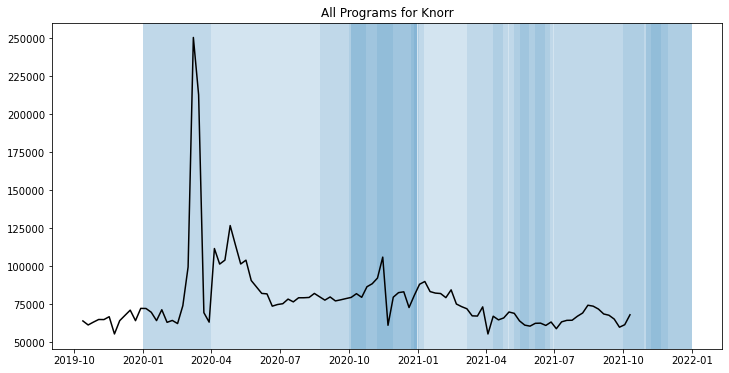

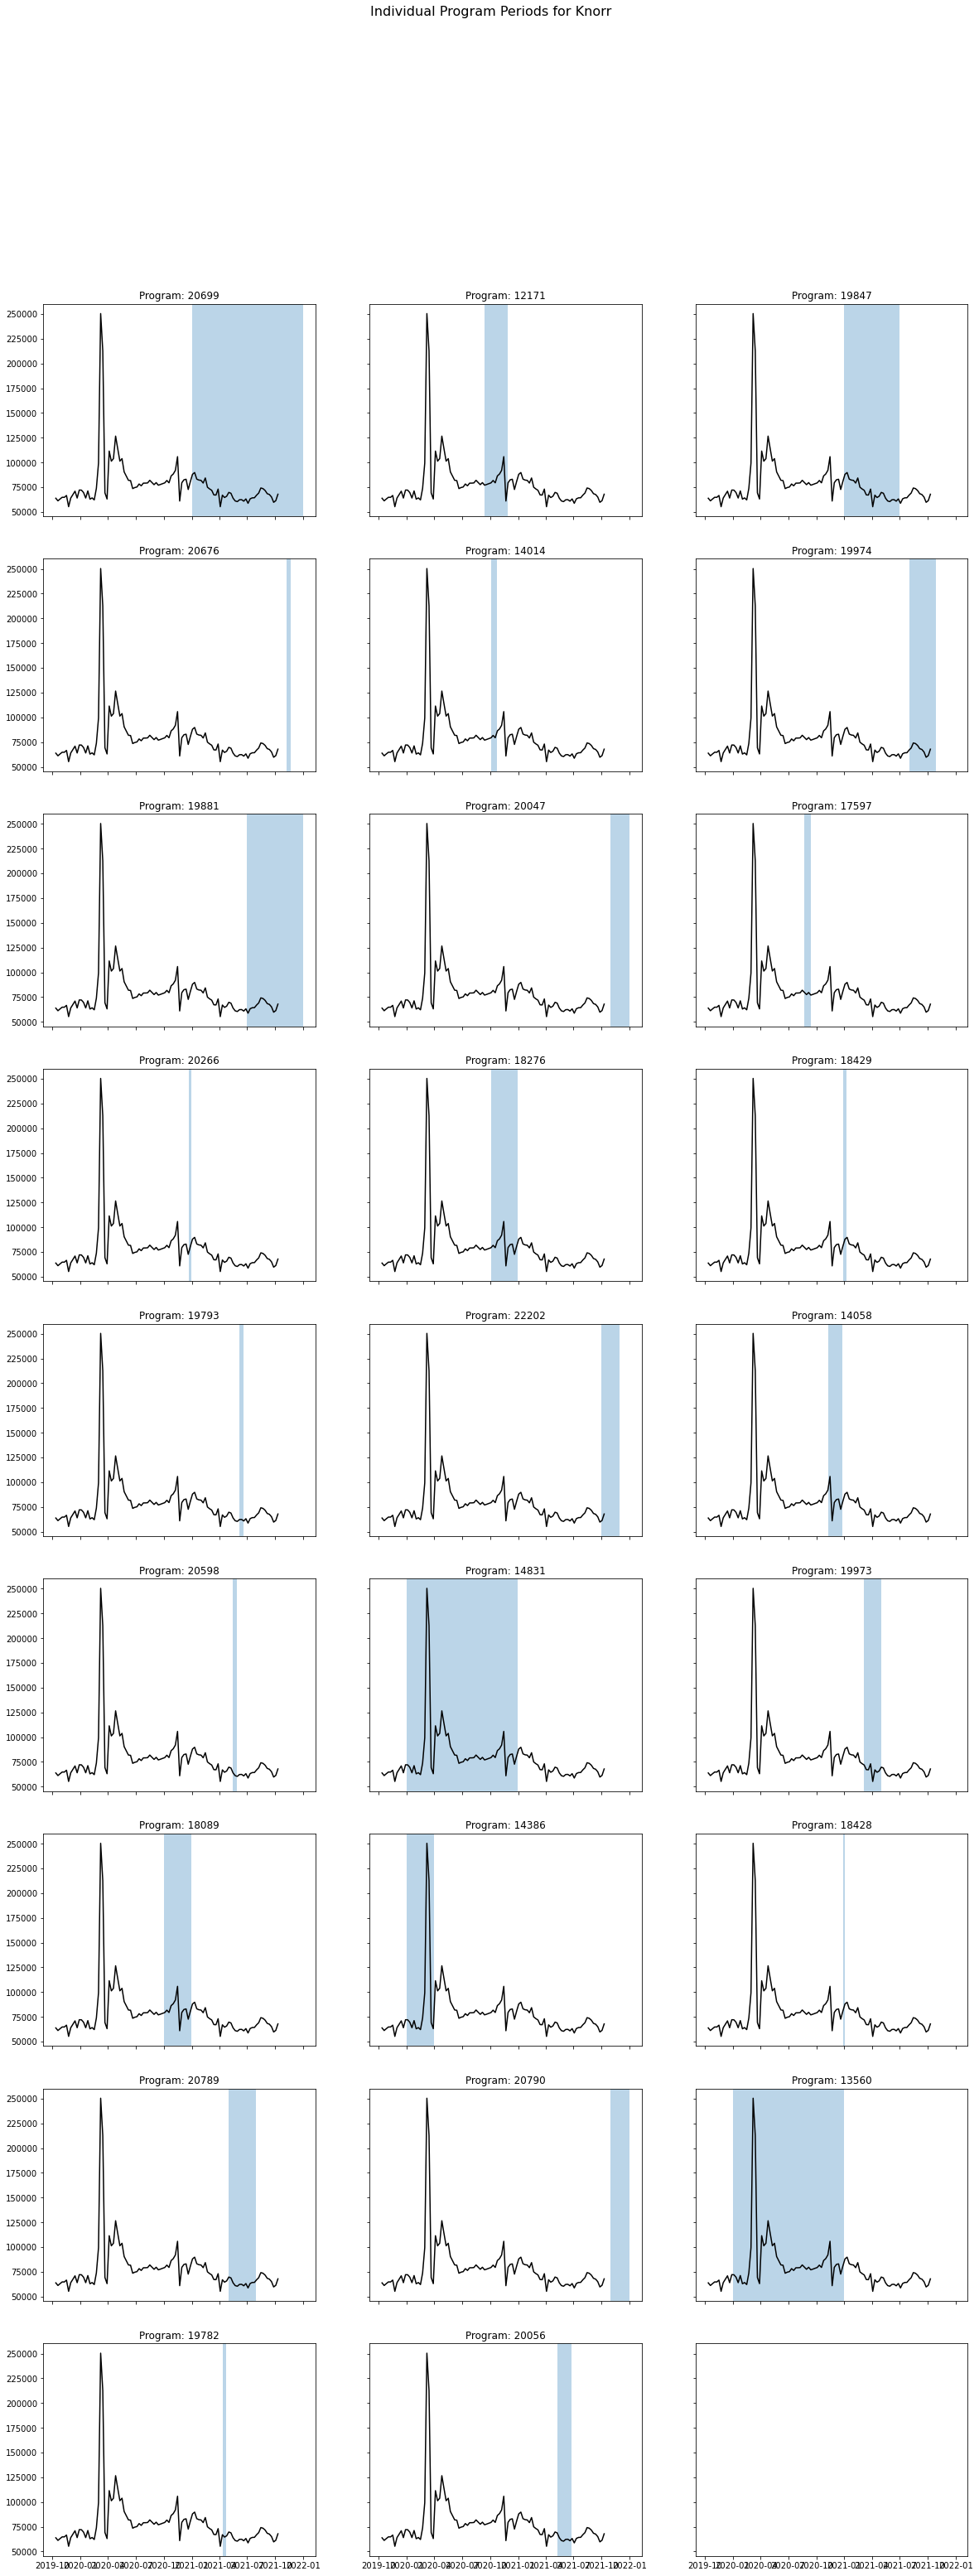

In [55]:
for i in set(pos_df.BrandName):
    plot_program_periods(pos_df, program_brand, i)

In [56]:
#TODO: add a similar function to the above but with highlighting color coded based on program tactics

# Modeling

### Adding subsections below for the types of modeling we've tried as well

### below function is intended to serve as model-agnostic scoring so we can compare approaches. We'll probably have to tinker with this as we go

In [57]:
def model_insample_score(yhat, skip_start = 0, skip_end = 0):
    """
    yhat: insample predicted values from your model
    skip_start: parameter to account for if you have lagging indicators in your model. Set equal to the number of rows your 
    model had to drop from the start of the time series in training
    skip_end: parameter to account for if you have leading indicators in your model. Set equal to the number of rows your
    model had to drop from the end of the time series in training
    """
    #todo: finish filling this out
    

#todo: add function for out of sample scoring
    

### ARIMA

In [58]:
sxmodel = pm.auto_arima(pos_df[['SalesUnit']],
                        trace = True,
                       error_action = 'ignore', 
                       suppress_warnings = True,
                       stepwise = True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2373.832, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2430.560, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2386.388, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2378.458, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2676.027, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2372.411, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2373.623, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2372.906, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2372.243, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2374.848, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2370.339, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2370.247, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2371.640, Time=0.09 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=2372.207, Time=0.23 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -1177.123
Date:                Mon, 14 Mar 2022   AIC                           2370.247
Time:                        15:49:05   BIC                           2391.478
Sample:                             0   HQIC                          2378.850
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.093e+04   5.21e+04      0.401      0.688   -8.12e+04    1.23e+05
ar.L1          0.3878      0.678      0.572      0.567      -0.941       1.716
ar.L2          0.0989      0.607      0.163      0.871      -1.091       1.289
ar.L3          0.2430      0.311      0.781      0.435      -0.367       0.853
ma.L1          0.5139      0.610      0.842      0.400      -0.682       1.710
ma.L2         -0.2583      0.814     -0.317      0.751      -1.854       1.338
ma.L3         -0.3938      0.463     -0.850      0.396      -1.302       0.515
sigma2      3.493e+08     45.899   7.61e+06      0.000    3.49e+08    3.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             13168.29
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             6.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.05e+22. Standard errors may be unstable.
"""

In [59]:
def model_evaluation(model, exog = None):
    start_insample = model.order[1]
    if exog is not None:
        yhat = model.predict_in_sample(exog, start = start_insample)
    else:
        yhat = model.predict_in_sample(start = start_insample)
    
    model.plot_diagnostics(figsize = (8,6))
    plt.show()
    
    plt.figure(figsize = (10,6))
    if start_insample == 0:
        plt.plot(pos_agg['WeekBeginningDate'], pos_agg['SalesUnit'], label = 'Actual Sales')
        plt.plot(pos_agg['WeekBeginningDate'], yhat, label = 'In-Sample Fitted Sales')
        plt.legend()
    else:
        plt.plot(pos_agg['WeekBeginningDate'][start_insample:], pos_agg['SalesUnit'][start_insample:], label = 'Actual Sales')
        plt.plot(pos_agg['WeekBeginningDate'][start_insample:], yhat, label = 'Predicted Sales')
        plt.legend()
    plt.show()
    
    print("In-sample model AIC: {}".format(model.aic()))
    actual = pos_agg['SalesUnit'][start_insample:]
    mae = np.mean(np.abs(yhat - actual))
    rmse = np.sqrt(np.mean((yhat - actual)**2))
    print("In-sample model MAE: {}".format(mae))
    print("In-sample model RMSE: {}".format(rmse))

D:\Users\nkeeley\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


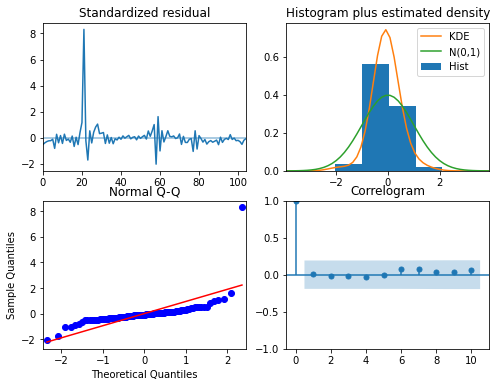

NameError: name 'pos_agg' is not defined

<Figure size 720x432 with 0 Axes>

In [60]:
model_evaluation(sxmodel)

## Regression Tree (w/o COVID variables)

References: https://d1wqtxts1xzle7.cloudfront.net/43514967/SKU_demand_forecasting_in_the_presence_o20160308-11493-1oyjps8-with-cover-page-v2.pdf?Expires=1644427342&Signature=cQD8mmeYFQlanASEmHEx93ZcutKZDwf8-bM4OMW1Zq40eDfitnX~jfMTc44zbOZ4N3HYJ1BCWs7aW1x1bj24FbB7SvUVsDYJlRIkcXduvaArci3Zr8n4H7MTPJYa3tOPKz9TdZ2Ee~pMimLt89baMWJUcZQPOrEM1O7~bsNjZKQOLh-Vs9iM20Fhg9t7PIERporrq8fIhgGk0LOZC04c93R0gtj2-PLhC9Yn2iIM1uBxuVD6ChMP-0ns6b4JbFEe5YcO~KJyCj~gU2LjO5I5a~PJ30bWlhDgOW3LO-EbJuZEGds58sDst9TKx6HxgppRyH~kf~ic8Me2cIJboZe9-A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

In [ ]:
## Adjust data so it conforms to format. 

# D_ist = sales, product (SKU), store, week (t), active promotion dummy (TV, radio, window),
# active discount percentage in week t

# M_ist = smoothed number of SKU items sold up to week t


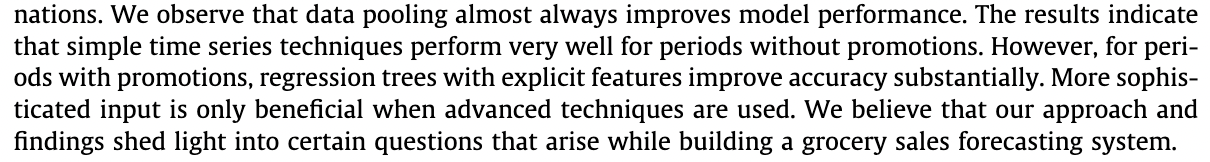

In [ ]:
## Utility functions

def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
                                  #"RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide_index())

### Data Preparation

In [128]:
## Read in Patrick's full dataset

pos_df

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,...,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53,Weekly_Spend
0,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,18073,80419.69,Talenti,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,28625,116499.52,Axe Deo,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,22593,100002.45,Breyers,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,13242,54972.16,POND'S,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6902,219425,1010887.31,Degree MB,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6903,224,1157.37,Emerge,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6904,259489,1656981.15,Dove Men Face,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6905,3891,34621.73,Shea Moisture Men Face,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596


In [425]:
## Creating week variable. Make this dummy variables!! Or months, or biweekly. Accounts for season

df_rt=pos_df.copy().sort_values(by="WeekBeginningDate")

In [426]:
df_rt

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,...,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53,Weekly_Spend
0,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
29,6006,20075.89,St. Ives HBL,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
30,0,0.00,Shea Moisture,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
31,121556,439119.27,TRESemme,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
32,2077,6402.62,Pure Leaf,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,4558,28312.77,Dove HBL,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6857,17900,375740.46,TIGI,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6855,18305,95572.51,Axe PW,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596
6862,16453,97989.98,Simple,2022-02-13,2022-02-19,13,1,1,0,0,...,0,0,0,0,0,0,0,0,0,837820.279596


In [427]:
## NOTE: skip this. already have week number variable
df_rt["Week"]=np.arange(len(df_rt))
df_rt.head()
df_rt=df_rt.reset_index()
df_rt=df_rt.drop("index", axis=1)
df_rt.head()

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,...,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53,Weekly_Spend,Week
0,19298,21150.92,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0
1,6006,20075.89,St. Ives HBL,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,1
2,0,0.00,Shea Moisture,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,2
3,121556,439119.27,TRESemme,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,3
4,2077,6402.62,Pure Leaf,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,4


In [428]:
df_rt.iloc[1000:1100]

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,...,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53,Weekly_Spend,Week
1000,63125,212007.54,Vaseline,2020-02-16,2020-02-22,1,0,2,0,0,...,0,0,0,0,0,0,0,0,635319.109669,1000
1001,119446,805150.53,Dove Bath,2020-02-16,2020-02-22,1,0,2,0,0,...,0,0,0,0,0,0,0,0,635319.109669,1001
1002,6944,34938.84,Axe PW,2020-02-16,2020-02-22,1,0,2,0,0,...,0,0,0,0,0,0,0,0,635319.109669,1002
1003,66489,296788.59,Degree MB,2020-02-16,2020-02-22,1,0,2,0,0,...,0,0,0,0,0,0,0,0,635319.109669,1003
1004,110554,426621.49,TRESemme,2020-02-16,2020-02-22,1,0,2,0,0,...,0,0,0,0,0,0,0,0,635319.109669,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-1,-3.12,Pure Leaf,2020-03-01,2020-03-07,1,0,2,0,0,...,0,0,0,0,0,0,0,0,602590.943058,1095
1096,54,1587.18,AHC,2020-03-01,2020-03-07,1,0,2,0,0,...,0,0,0,0,0,0,0,0,602590.943058,1096
1097,7429,38206.01,Axe PW,2020-03-01,2020-03-07,1,0,2,0,0,...,0,0,0,0,0,0,0,0,602590.943058,1097
1098,28486,121483.84,St. Ives Face,2020-03-01,2020-03-07,1,0,2,0,0,...,0,0,0,0,0,0,0,0,602590.943058,1098


In [429]:
start = datetime.datetime.strptime("2020-03-01", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-05-31", "%Y-%m-%d")
test=df_rt.WeekBeginningDate.iloc[1000]
if start <= test <= end:
    df_rt.covid_panic=1

In [430]:
## Adjusted data for COVID

df_rt["covid_panic"]=0 
df_rt['covid_panic'] = [1 if (start <= x <= end) else 0 for x in df_rt['WeekBeginningDate']]
df_rt.columns

Index(['SalesUnit', 'SalesDollar', 'BrandName', 'WeekBeginningDate',
       'WeekEndingDate', 'Digital Marketing', 'Sampling',
       'Retailer Partnership', 'Printed Out-of-Store Media',
       'Unallocated Funding', 'Price / Promotion / Couponing', 'UNK',
       'Ecommerce', 'Program Development Costs', 'In-Store Marketing',
       'week_num', 'Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6',
       'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12',
       'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18',
       'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24',
       'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30',
       'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36',
       'Week_37', 'Week_38', 'Week_39', 'Week_40', 'Week_41', 'Week_42',
       'Week_43', 'Week_44', 'Week_45', 'Week_46', 'Week_47', 'Week_48',
       'Week_49', 'Week_50', 'Week_51', 'Week_52', 'Week_53', 'Weekly_Spend',
      

In [431]:
## Move week column to front of dataset, SalesUnit to the back.

unit_t=df_rt.SalesUnit
key_columns=["week_num","SalesUnit"]

In [432]:
#[col for col in df_rt if (col != key_columns[0] & col !=key_columns[1])]

new_columns=[key_columns[0]]
for col in df_rt.columns:
    if (col != key_columns[0]) and (col!=key_columns[1]):
        new_columns.append(col)
new_columns.append(key_columns[1])
df_rt.week_num.value_counts()

46    179
50    178
51    177
2     177
42    176
6     176
3     176
47    176
48    176
49    176
41    175
1     175
4     175
43    174
5     174
52    173
45    173
44    173
37    124
39    122
38    121
40    121
36    110
35    109
34    108
33    108
28    108
32    108
30    108
29    108
15    108
12    108
7     108
10    108
31    107
23    107
24    107
27    107
8     107
11    107
25    106
26    106
19    106
9     106
21    106
16    106
20    105
13    105
17    105
18    105
22    105
14    104
53     54
Name: week_num, dtype: int64

In [433]:
## Drop week dummies

df_rt = df_rt[new_columns]
df_rt = df_rt[df_rt.columns.drop(list(df_rt.filter(regex='Week_')))]
df_rt.columns


Index(['week_num', 'SalesDollar', 'BrandName', 'WeekBeginningDate',
       'WeekEndingDate', 'Digital Marketing', 'Sampling',
       'Retailer Partnership', 'Printed Out-of-Store Media',
       'Unallocated Funding', 'Price / Promotion / Couponing', 'UNK',
       'Ecommerce', 'Program Development Costs', 'In-Store Marketing',
       'Weekly_Spend', 'Week', 'covid_panic', 'SalesUnit'],
      dtype='object')

In [183]:
df_rt.to_csv("rf_dataset.csv")

In [192]:
df_rt.iloc[1005]

week_num                                           7
SalesDollar                                 13995.46
BrandName                                 Lever 2000
WeekBeginningDate                2020-02-16 00:00:00
WeekEndingDate                   2020-02-22 00:00:00
Digital Marketing                                  1
Sampling                                           0
Retailer Partnership                               2
Printed Out-of-Store Media                         0
Unallocated Funding                                0
Price / Promotion / Couponing                      3
UNK                                              103
Ecommerce                                          0
Program Development Costs                          0
In-Store Marketing                                 1
Weekly_Spend                           635319.109669
covid_panic                                        0
SalesUnit                                       2548
Name: 965, dtype: object

In [434]:
# Clean up for just variables of interest. Remove Week end/start dates.

len(brands)
#df_rt.BrandName.value_counts()
df_rt=df_rt.drop(["WeekEndingDate"], axis=1)
df_rt.columns
    


Index(['week_num', 'SalesDollar', 'BrandName', 'WeekBeginningDate',
       'Digital Marketing', 'Sampling', 'Retailer Partnership',
       'Printed Out-of-Store Media', 'Unallocated Funding',
       'Price / Promotion / Couponing', 'UNK', 'Ecommerce',
       'Program Development Costs', 'In-Store Marketing', 'Weekly_Spend',
       'Week', 'covid_panic', 'SalesUnit'],
      dtype='object')

In [437]:
df_rt=df_rt.set_index("WeekBeginningDate")

In [467]:
unpooled_meta=pd.DataFrame(columns=["Brand","Error","Model"])
brand_df_list=pd.DataFrame(columns=["SalesUnit_t","predictions"])
single_brand=pd.DataFrame(columns=["Predicted","Actual"])
models=[]
errors=[]
n_percent=.2

In [456]:
temp=df_rt[df_rt.BrandName==brands[0]].drop("BrandName",axis=1)
temp=series_to_supervised(temp,1,1)
error, df, model=walk_forward_rf_validation(temp, n_test)
df

>expected=40398.0, predicted=43611.4
>expected=37372.0, predicted=43008.1
>expected=34169.0, predicted=38687.1
>expected=140864.0, predicted=68215.0
>expected=137966.0, predicted=112597.2
>expected=139508.0, predicted=127264.3
>expected=141112.0, predicted=135551.3
>expected=106408.0, predicted=127775.1
>expected=106888.0, predicted=116229.1
>expected=108913.0, predicted=110865.7
>expected=110753.0, predicted=110012.4
>expected=130887.0, predicted=110298.8
>expected=124569.0, predicted=123851.7
>expected=106687.0, predicted=112647.7
>expected=109636.0, predicted=109729.2
>expected=114032.0, predicted=113836.8
>expected=125411.0, predicted=126052.3
>expected=126758.0, predicted=126691.5
>expected=129406.0, predicted=129884.1
>expected=135320.0, predicted=132179.3
>expected=130096.0, predicted=133656.0
>expected=124467.0, predicted=131288.5
>expected=128786.0, predicted=127518.1
>expected=131853.0, predicted=129473.8
>expected=116615.0, predicted=123307.0


,SalesUnit_t,predictions
WeekBeginningDate,,
2021-08-29,40398,43611.385
2021-09-05,37372,43008.061
2021-09-12,34169,38687.127
2021-09-19,140864,68214.965
2021-09-26,137966,112597.208
2021-10-03,139508,127264.265
2021-10-10,141112,135551.300
2021-10-17,106408,127775.138
2021-10-24,106888,116229.115


In [453]:
x=pd.DataFrame(actual)
x["predictions"]=predictions
x

,SalesUnit_t,predictions
WeekBeginningDate,,
2021-08-29,40398,43498.052
2021-09-05,37372,43339.857
2021-09-12,34169,38682.645
2021-09-19,140864,67655.811
2021-09-26,137966,113191.184
2021-10-03,139508,130044.320
2021-10-10,141112,135797.103
2021-10-17,106408,128626.089
2021-10-24,106888,116650.492


In [283]:
#df_unpooled=df_rt[df_rt.BrandName==tgt_brand].drop("BrandName",axis=1)
## Walk forward rf validation: pooled


#n_test=math.ceil(n_percent*df_unpooled.shape[0])
#n_test
#temp=series_to_supervised(df_unpooled,1,1)
#error, actual, predictions, model=walk_forward_rf_validation(temp, n_test)

In [468]:
for brand in brands:
    tgt_brand=brand
    print(tgt_brand)
    single_brand=pd.DataFrame(columns=["SalesUnit_t","predictions"])
    df_unpooled=df_rt[df_rt.BrandName==tgt_brand].drop("BrandName",axis=1)
    n_test=math.ceil(n_percent*df_unpooled.shape[0])
    temp=series_to_supervised(df_unpooled,2,1)
    if(df_unpooled.shape[0]>10):
        error, df, model=walk_forward_rf_validation(temp, n_test)
        df["brand"]=tgt_brand
        brand_df_list=pd.concat([brand_df_list,df],axis=0)
        models.append(model)
        errors.append(error)
    else:
        single_brand["SalesUnit_t"]=np.nan
        single_brand["predictions"]=np.nan
        brand_df_list=pd.concat([brand_df_list,df],axis=0)
        models.append(np.nan)
        errors.append(np.nan)



Hellmann's
>expected=40398.0, predicted=43354.8
>expected=37372.0, predicted=43338.7
>expected=34169.0, predicted=38731.4
>expected=140864.0, predicted=68543.0
>expected=137966.0, predicted=111829.9
>expected=139508.0, predicted=127971.5
>expected=141112.0, predicted=135363.5
>expected=106408.0, predicted=130211.3
>expected=106888.0, predicted=116992.5
>expected=108913.0, predicted=111350.7
>expected=110753.0, predicted=111065.7
>expected=130887.0, predicted=110963.8
>expected=124569.0, predicted=118327.9
>expected=106687.0, predicted=113295.2
>expected=109636.0, predicted=109428.7
>expected=114032.0, predicted=113683.0
>expected=125411.0, predicted=123818.4
>expected=126758.0, predicted=125281.2
>expected=129406.0, predicted=128372.5
>expected=135320.0, predicted=132221.9
>expected=130096.0, predicted=132739.2
>expected=124467.0, predicted=131443.8
>expected=128786.0, predicted=127500.4
>expected=131853.0, predicted=129272.8
>expected=116615.0, predicted=122998.3
Shea Moisture PW
>exp

In [474]:
brand_df_list.to_csv("pat_with_tactics_df.csv")
unpooled_meta=pd.DataFrame(columns=["Brand","Error","Model"])
unpooled_meta.Brand=brands
unpooled_meta.Error=errors
unpooled_meta.Model=models
unpooled_meta.to_csv("pat_with_tactics_metadata.csv")

In [ ]:
## Create without tactics



In [421]:
## Create w/tactics data frame

unpooled_meta.Brand=brands
unpooled_meta.Error=errors
unpooled_meta.Model=models
brand_dfs=pd.DataFrame(columns=["brand","df"])
brand_dfs.brand=brands
brand_dfs.df=brand_df_list
with_unpooled_metadata=unpooled_meta.copy()
with_results=brand_dfs.copy()

#unpooled_meta.to_csv("with_tactics_unpooled_metadata.csv")
#brand_dfs.to_csv("with_tactics_unpooled_results.csv")

In [424]:
with_results.iloc[0][1]

,Predicted,Actual,Absolute Error
0,43379.689,40398,2981.689
1,43517.573,37372,6145.573
2,38561.902,34169,4392.902
3,69439.254,140864,71424.746
4,114276.621,137966,23689.379
5,127223.792,139508,12284.208
6,135032.795,141112,6079.205
7,110655.037,106408,4247.037
8,111420.079,106888,4532.079
9,111539.093,108913,2626.093


In [478]:
## Without tactics data analysis

drop=df_rt.iloc[:,3:-3]
drop

,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing,Weekly_Spend
WeekBeginningDate,,,,,,,,,,,
2019-10-13,0,0,0,0,0,0,0,0,0,0,0.000000
2019-10-13,0,0,0,0,0,0,0,0,0,0,0.000000
2019-10-13,0,0,0,0,0,0,0,0,0,0,0.000000
2019-10-13,0,0,0,0,0,0,0,0,0,0,0.000000
2019-10-13,0,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-13,13,1,1,0,0,17,0,45,3,0,837820.279596
2022-02-13,13,1,1,0,0,17,0,45,3,0,837820.279596
2022-02-13,13,1,1,0,0,17,0,45,3,0,837820.279596


In [479]:
df_without=df_rt.drop(drop,axis=1)
df_without

,week_num,SalesDollar,BrandName,Week,covid_panic,SalesUnit
WeekBeginningDate,,,,,,
2019-10-13,41,21150.92,Knorr,0,0,19298
2019-10-13,41,20075.89,St. Ives HBL,1,0,6006
2019-10-13,41,0.00,Shea Moisture,2,0,0
2019-10-13,41,439119.27,TRESemme,3,0,121556
2019-10-13,41,6402.62,Pure Leaf,4,0,2077
...,...,...,...,...,...,...
2022-02-13,6,28312.77,Dove HBL,6902,0,4558
2022-02-13,6,375740.46,TIGI,6903,0,17900
2022-02-13,6,95572.51,Axe PW,6904,0,18305


In [480]:
unpooled_meta=pd.DataFrame(columns=["Brand","Error","Model"])
brand_df_list=pd.DataFrame(columns=["SalesUnit_t","predictions"])
single_brand=pd.DataFrame(columns=["Predicted","Actual"])
models=[]
errors=[]
n_percent=.2

In [481]:
for brand in brands:
    tgt_brand=brand
    print(tgt_brand)
    single_brand=pd.DataFrame(columns=["SalesUnit_t","predictions"])
    df_unpooled=df_without[df_without.BrandName==tgt_brand].drop("BrandName",axis=1)
    n_test=math.ceil(n_percent*df_unpooled.shape[0])
    temp=series_to_supervised(df_unpooled,2,1)
    if(df_unpooled.shape[0]>10):
        error, df, model=walk_forward_rf_validation(temp, n_test)
        df["brand"]=tgt_brand
        brand_df_list=pd.concat([brand_df_list,df],axis=0)
        models.append(model)
        errors.append(error)
    else:
        single_brand["SalesUnit_t"]=np.nan
        single_brand["predictions"]=np.nan
        brand_df_list=pd.concat([brand_df_list,df],axis=0)
        models.append(np.nan)
        errors.append(np.nan)



Hellmann's
>expected=40398.0, predicted=43386.6
>expected=37372.0, predicted=44915.9
>expected=34169.0, predicted=38799.8
>expected=140864.0, predicted=67476.2
>expected=137966.0, predicted=115244.0
>expected=139508.0, predicted=128883.9
>expected=141112.0, predicted=136278.5
>expected=106408.0, predicted=130294.8
>expected=106888.0, predicted=118001.7
>expected=108913.0, predicted=112677.6
>expected=110753.0, predicted=110450.0
>expected=130887.0, predicted=111560.5
>expected=124569.0, predicted=124358.4
>expected=106687.0, predicted=112985.1
>expected=109636.0, predicted=109271.2
>expected=114032.0, predicted=113819.6
>expected=125411.0, predicted=125422.0
>expected=126758.0, predicted=124181.9
>expected=129406.0, predicted=126305.0
>expected=135320.0, predicted=130581.2
>expected=130096.0, predicted=132665.9
>expected=124467.0, predicted=131220.5
>expected=128786.0, predicted=127767.5
>expected=131853.0, predicted=130282.0
>expected=116615.0, predicted=121937.0
Shea Moisture PW
>exp

In [482]:
brand_df_list.to_csv("pat_without_tactics_df.csv")
unpooled_meta=pd.DataFrame(columns=["Brand","Error","Model"])
unpooled_meta.Brand=brands
unpooled_meta.Error=errors
unpooled_meta.Model=models
unpooled_meta.to_csv("pat_without_tactics_metadata.csv")

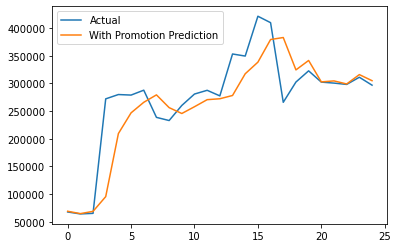

In [374]:
plt.plot(brand_dfs.iloc[9][1].Actual, label='Actual')
plt.plot(brand_dfs.iloc[9][1].Predicted, label='With Promotion Prediction')
plt.legend()
plt.show()

In [384]:
unpooled_meta=pd.DataFrame(columns=["Brand","Error","Model"])
brand_df_list=[]
single_brand=pd.DataFrame(columns=["Predicted","Actual"])
models=[]
errors=[]
n_percent=.2

In [385]:
for brand in brands:
    tgt_brand=brand
    print(tgt_brand)
    single_brand=pd.DataFrame(columns=["Predicted","Actual","Absolute Error"])
    df_unpooled=df_without[df_without.BrandName==tgt_brand].drop("BrandName",axis=1)
    n_test=math.ceil(n_percent*df_unpooled.shape[0])
    temp=series_to_supervised(df_unpooled,2,1)
    if(df_unpooled.shape[0]>10):
        error, actual, predictions, model=walk_forward_rf_validation(temp, n_test)
        single_brand["Predicted"]=predictions
        single_brand["Actual"]=actual.values
        single_brand["Absolute Error"]=abs(single_brand.Actual-single_brand.Predicted)
        brand_df_list.append(single_brand)
        models.append(model)
        errors.append(error)
    else:
        single_brand["Predicted"]=np.nan
        single_brand["Actual"]=np.nan
        single_brand["Absolute Error"]=np.nan
        brand_df_list.append(single_brand)
        models.append(np.nan)
        errors.append(np.nan)

Hellmann's
>expected=40398.0, predicted=43662.5
>expected=37372.0, predicted=45125.0
>expected=34169.0, predicted=38789.1
>expected=140864.0, predicted=68406.2
>expected=137966.0, predicted=111804.8
>expected=139508.0, predicted=128566.1
>expected=141112.0, predicted=135595.8
>expected=106408.0, predicted=111604.7
>expected=106888.0, predicted=112740.4
>expected=108913.0, predicted=111550.9
>expected=110753.0, predicted=110190.8
>expected=130887.0, predicted=111537.7
>expected=124569.0, predicted=123758.5
>expected=106687.0, predicted=112729.7
>expected=109636.0, predicted=109301.5
>expected=114032.0, predicted=113788.7
>expected=125411.0, predicted=125919.1
>expected=126758.0, predicted=124705.1
>expected=129406.0, predicted=127721.6
>expected=135320.0, predicted=132890.3
>expected=130096.0, predicted=135596.7
>expected=124467.0, predicted=132709.5
>expected=128786.0, predicted=128548.1
>expected=131853.0, predicted=130425.2
>expected=116615.0, predicted=120913.5
Shea Moisture PW
>exp

In [388]:
## Create w/tactics data frame

unpooled_meta.Brand=brands
unpooled_meta.Error=errors
unpooled_meta.Model=models
brand_dfs=pd.DataFrame(columns=["brand","df"])
brand_dfs.brand=brands
brand_dfs.df=brand_df_list
brand_dfs
unpooled_meta.to_csv("no_tactics_unpooled_metadata.csv")
brand_dfs.to_csv("no_tactics_unpooled_results.csv")

In [409]:
none_unpooled_meta=unpooled_meta.copy()
none_results=brand_dfs.copy()

,Predicted,Actual,Absolute Error
0,43662.512,40398,3264.512
1,45124.995,37372,7752.995
2,38789.082,34169,4620.082
3,68406.216,140864,72457.784
4,111804.775,137966,26161.225
5,128566.087,139508,10941.913
6,135595.848,141112,5516.152
7,111604.735,106408,5196.735
8,112740.425,106888,5852.425
9,111550.855,108913,2637.855


In [398]:
df_tactics=pd.read_csv("with_tactics_unpooled_results.csv")
df_tactics=df_tactics.drop("Unnamed: 0",axis=1)
df_tactics

,brand,df
0,Hellmann's,Predicted Actual Absolute Error\n0 4...
1,Shea Moisture PW,Predicted Actual Absolute Error\n0 35689...
2,Dove Deo,Predicted Actual Absolute Error\n0 5...
3,Baby Dove,Predicted Actual Absolute Error\n0 124...
4,Dove HBL,Predicted Actual Absolute Error\n0 3...
...,...,...
67,Suave Mens Hair,Predicted Actual Absolute Error\n0 42...
68,Caress,Predicted Actual Absolute Error\n0 138...
69,Dove Hair,Predicted Actual Absolute Error\n0 4...
70,Axe Hair,Predicted Actual Absolute Error\n0 22...


In [399]:
df_no_tactics=pd.read_csv("no_tactics_unpooled_results.csv")
df_no_tactics=df_no_tactics.drop("Unnamed: 0",axis=1)
df_no_tactics

,brand,df
0,Hellmann's,Predicted Actual Absolute Error\n0 4...
1,Shea Moisture PW,Predicted Actual Absolute Error\n0 35708...
2,Dove Deo,Predicted Actual Absolute Error\n0 5...
3,Baby Dove,Predicted Actual Absolute Error\n0 124...
4,Dove HBL,Predicted Actual Absolute Error\n0 3...
...,...,...
67,Suave Mens Hair,Predicted Actual Absolute Error\n0 41...
68,Caress,Predicted Actual Absolute Error\n0 135...
69,Dove Hair,Predicted Actual Absolute Error\n0 4...
70,Axe Hair,Predicted Actual Absolute Error\n0 22...


In [401]:
plt.plot(df_tactics.iloc[0][1].Actual, label='Actual')
plt.plot(df_tactics.iloc[0][1].Predicted, label='With Promotion Prediction')
plt.plot(df_no_tactics.iloc[0][1].Predicted, label='Without Promotion Prediction')
plt.legend()
plt.show()

AttributeError: 'str' object has no attribute 'Actual'

ValueError: DataFrame constructor not properly called!

In [201]:
## Pooled model data prep

df_pooled=df_rt.copy()
df_pooled.head()

,week_num,SalesDollar,BrandName,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,Program Development Costs,In-Store Marketing,Weekly_Spend,covid_panic,SalesUnit
0,41,21150.92,Knorr,0,0,0,0,0,0,0,0,0,0,0.0,0,19298
29,41,20075.89,St. Ives HBL,0,0,0,0,0,0,0,0,0,0,0.0,0,6006
30,41,0.00,Shea Moisture,0,0,0,0,0,0,0,0,0,0,0.0,0,0
31,41,439119.27,TRESemme,0,0,0,0,0,0,0,0,0,0,0.0,0,121556
32,41,6402.62,Pure Leaf,0,0,0,0,0,0,0,0,0,0,0.0,0,2077


In [214]:
## Create BrandName dummies

temp=pd.DataFrame(df_pooled.BrandName)
temp=pd.get_dummies(temp)
temp

## Merge dummies with main dataframe

df_pooled=pd.concat([df_pooled,temp],axis=1)
df_pooled.iloc[0]

week_num                    41
SalesDollar           21150.92
BrandName                Knorr
Digital Marketing            0
Sampling                     0
                        ...   
BrandName_TIGI               0
BrandName_TRESemme           0
BrandName_Talenti            0
BrandName_Tazo               0
BrandName_Vaseline           0
Name: 0, Length: 88, dtype: object

In [215]:
'''
df_rt = df_rt[new_columns]
df_rt.drop("SalesUnit",axis=1,inplace=True)
df_rt["SalesUnit"]=unit_t
df_rt.head()

## Isolate variables of interest

#df_rt=df_rt.set_index("Week")
cut=["Week","SalesDollar","BrandName","WeekBeginningDate","WeekEndingDate"] #"Week",
df_rt=df_rt.loc[:, ~df_rt.columns.isin(cut)]
df_rt = df_rt[df_rt.columns.drop(list(df_rt.filter(regex='ProgramId_')))]
df_rt.columns
'''

'\ndf_rt = df_rt[new_columns]\ndf_rt.drop("SalesUnit",axis=1,inplace=True)\ndf_rt["SalesUnit"]=unit_t\ndf_rt.head()\n\n## Isolate variables of interest\n\n#df_rt=df_rt.set_index("Week")\ncut=["Week","SalesDollar","BrandName","WeekBeginningDate","WeekEndingDate"] #"Week",\ndf_rt=df_rt.loc[:, ~df_rt.columns.isin(cut)]\ndf_rt = df_rt[df_rt.columns.drop(list(df_rt.filter(regex=\'ProgramId_\')))]\ndf_rt.columns\n'

In [77]:
df_rt.head(20).shape

(20, 12)

In [216]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}_t-%d'.format(df.columns[j]) % (i)) for j in range(n_vars)] #var%d
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}_t'.format(df.columns[j])) for j in range(n_vars)]
        else:
            names += [('{}_t+%d'.format(df.columns[j]) % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [217]:
temp=series_to_supervised(df_pooled,1,1)
temp

,week_num_t-1,SalesDollar_t-1,BrandName_t-1,Digital Marketing_t-1,Sampling_t-1,Retailer Partnership_t-1,Printed Out-of-Store Media_t-1,Unallocated Funding_t-1,Price / Promotion / Couponing_t-1,UNK_t-1,...,BrandName_Suave Deo_t,BrandName_Suave HBL_t,BrandName_Suave Hair_t,BrandName_Suave Mens Hair_t,BrandName_Sundial_t,BrandName_TIGI_t,BrandName_TRESemme_t,BrandName_Talenti_t,BrandName_Tazo_t,BrandName_Vaseline_t
29,41,21150.92,Knorr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
30,41,20075.89,St. Ives HBL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
31,41,0.00,Shea Moisture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
32,41,439119.27,TRESemme,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
33,41,6402.62,Pure Leaf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,6,282169.04,Baby Dove,13.0,1.0,1.0,0.0,0.0,17.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6857,6,28312.77,Dove HBL,13.0,1.0,1.0,0.0,0.0,17.0,0.0,...,0,0,0,0,0,1,0,0,0,0
6855,6,375740.46,TIGI,13.0,1.0,1.0,0.0,0.0,17.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6862,6,95572.51,Axe PW,13.0,1.0,1.0,0.0,0.0,17.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [433]:
'''
What do about NaNs? Imputed average.
Enough lagged weeks? 
Only has one brand...? We will need to dummify brands too.
Doesn't contain store data like the paper model.
Double counting for tactics and program IDs. Max vs. Sum? Removed tactics.
Perhaps log transform salesunits to reduce variance.
'''

"\nWhat do about NaNs? Imputed average.\nEnough lagged weeks? \nOnly has one brand...? We will need to dummify brands too.\nDoesn't contain store data like the paper model.\nDouble counting for tactics and program IDs. Max vs. Sum? Removed tactics.\nPerhaps log transform salesunits to reduce variance.\n"

## Walk-Forward Validation Formatting: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [244]:

from tqdm import tqdm

In [218]:
def train_test_split(data, n_test):
    return data.iloc[:-n_test, :], data.iloc[-n_test:, :]


In [219]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = pd.DataFrame(train)
    # split into input and output columns
    trainX, trainy = train.iloc[:, :-1], train.iloc[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0], model

In [220]:
# fit an XGB model and make a one step prediction
def xgb_forecast(train, testX):
    # transform list into array
    train = pd.DataFrame(train)
    # split into input and output columns
    trainX, trainy = train.iloc[:, :-1], train.iloc[:, -1]
    # fit xgb model
    model = XGBRegressor(n_estimators = 500)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0], model

# best params from orig code
#{'ccp_alpha': 0, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}

In [221]:
# fit an RT model and make a one step prediction
def rt_forecast(train, testX):
    # transform list into array
    train = pd.DataFrame(train)
    # split into input and output columns
    trainX, trainy = train.iloc[:, :-1], train.iloc[:, -1]
    # fit rt model
    model = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=10,
                           max_features=.1,
                           min_impurity_decrease=.001,
                           ccp_alpha=0,
                           random_state=201)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0], model

# best params from orig code
#{'ccp_alpha': 0,'max_depth': 10,'max_features': 0.1,'min_impurity_decrease': 0.001, 
# 'min_samples_split': 10}

In [454]:
def walk_forward_rf_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = pd.DataFrame(train)
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # fit model on history and make a prediction
        yhat, model = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history=history.append(test.iloc[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test.iloc[:, -1], predictions)
    x=pd.DataFrame(test.iloc[:,-1])
    x["predictions"]=predictions
    return error, x, model

In [223]:
def walk_forward_xgb_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = pd.DataFrame(train)
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgb_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history=history.append(test.iloc[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test.iloc[:, -1], predictions)
    return error, test.iloc[:, -1], predictions, model

In [224]:
def walk_forward_rt_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = pd.DataFrame(train)
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # fit model on history and make a prediction
        yhat, model = rt_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history=history.append(test.iloc[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test.iloc[:, -1], predictions)
    return error, test.iloc[:, -1], predictions, model

In [229]:
df_pooled=df_pooled.drop("BrandName",axis=1)
df_pooled.head()

,week_num,SalesDollar,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,...,BrandName_Suave Deo,BrandName_Suave HBL,BrandName_Suave Hair,BrandName_Suave Mens Hair,BrandName_Sundial,BrandName_TIGI,BrandName_TRESemme,BrandName_Talenti,BrandName_Tazo,BrandName_Vaseline
0,41,21150.92,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,41,20075.89,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,41,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,41,439119.27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
32,41,6402.62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [231]:
## Reshuffle variable names

key_columns=["week_num","SalesUnit"]
new_columns=[key_columns[0]]
for col in df_pooled.columns:
    if (col != key_columns[0]) and (col!=key_columns[1]):
        new_columns.append(col)
new_columns.append(key_columns[1])

In [233]:
df_pooled=df_pooled[new_columns]
df_pooled

,week_num,SalesDollar,Digital Marketing,Sampling,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Price / Promotion / Couponing,UNK,Ecommerce,...,BrandName_Suave HBL,BrandName_Suave Hair,BrandName_Suave Mens Hair,BrandName_Sundial,BrandName_TIGI,BrandName_TRESemme,BrandName_Talenti,BrandName_Tazo,BrandName_Vaseline,SalesUnit
0,41,21150.92,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19298
29,41,20075.89,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6006
30,41,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,41,439119.27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,121556
32,41,6402.62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,6,28312.77,13,1,1,0,0,17,0,45,...,0,0,0,0,0,0,0,0,0,4558
6857,6,375740.46,13,1,1,0,0,17,0,45,...,0,0,0,0,1,0,0,0,0,17900
6855,6,95572.51,13,1,1,0,0,17,0,45,...,0,0,0,0,0,0,0,0,0,18305
6862,6,97989.98,13,1,1,0,0,17,0,45,...,0,0,0,0,0,0,0,0,0,16453


In [234]:
## Create storage data frame:

results_lag4=pd.DataFrame(columns=["actual","predictions"])
meta_lag4=pd.DataFrame(columns=["mae","model"])
meta_lag4

,mae,model


In [247]:
## Walk forward rf validation: pooled

n_percent=.2
n_test=math.ceil(n_percent*df_pooled.shape[0])
n_test
temp=series_to_supervised(df_pooled,1,1)
error, actual, predictions, model=walk_forward_rf_validation(temp, n_test)

  0%|          | 1/1382 [01:35<36:37:29, 95.47s/it]

>expected=259970.0, predicted=253762.0


  0%|          | 2/1382 [03:13<37:07:35, 96.85s/it]

>expected=36302.0, predicted=59827.0


  0%|          | 3/1382 [04:50<37:06:48, 96.89s/it]

>expected=3974.0, predicted=7232.9


  0%|          | 4/1382 [06:27<37:07:46, 97.00s/it]

>expected=10533.0, predicted=8851.5


  0%|          | 5/1382 [08:02<36:54:21, 96.49s/it]

>expected=24252.0, predicted=18804.5


  0%|          | 6/1382 [09:38<36:48:51, 96.32s/it]

>expected=32718.0, predicted=35619.3


  1%|          | 7/1382 [11:16<36:54:26, 96.63s/it]

>expected=24826.0, predicted=75580.6


  1%|          | 8/1382 [12:54<37:05:41, 97.19s/it]

>expected=0.0, predicted=0.0


  1%|          | 9/1382 [14:33<37:15:23, 97.69s/it]

>expected=21387.0, predicted=21304.8


  1%|          | 10/1382 [16:11<37:13:55, 97.69s/it]

>expected=75.0, predicted=58.8


  1%|          | 11/1382 [17:48<37:10:12, 97.60s/it]

>expected=39540.0, predicted=33959.4


  1%|          | 12/1382 [19:26<37:07:57, 97.57s/it]

>expected=186094.0, predicted=93785.7


  1%|          | 13/1382 [21:01<36:54:14, 97.05s/it]

>expected=54297.0, predicted=58964.7


  1%|          | 14/1382 [22:38<36:51:34, 97.00s/it]

>expected=243641.0, predicted=235745.9


  1%|          | 15/1382 [24:15<36:49:38, 96.99s/it]

>expected=186366.0, predicted=219319.4


  1%|          | 16/1382 [25:56<37:12:20, 98.05s/it]

>expected=276465.0, predicted=242025.4


  1%|          | 17/1382 [27:31<36:52:32, 97.25s/it]

>expected=10100.0, predicted=14071.2


  1%|▏         | 18/1382 [29:08<36:45:34, 97.02s/it]

>expected=164937.0, predicted=233823.4


  1%|▏         | 19/1382 [30:44<36:38:36, 96.78s/it]

>expected=72060.0, predicted=67235.7


  1%|▏         | 20/1382 [32:20<36:32:56, 96.61s/it]

>expected=18987.0, predicted=15803.0


  2%|▏         | 21/1382 [33:56<36:28:15, 96.47s/it]

>expected=12509.0, predicted=10336.2


  2%|▏         | 22/1382 [35:32<36:22:38, 96.29s/it]

>expected=87549.0, predicted=81516.0


  2%|▏         | 23/1382 [37:08<36:17:54, 96.16s/it]

>expected=239861.0, predicted=177403.8


  2%|▏         | 24/1382 [38:50<36:59:38, 98.07s/it]

>expected=10622.0, predicted=17968.4


  2%|▏         | 25/1382 [40:26<36:42:35, 97.39s/it]

>expected=169019.0, predicted=213561.8


  2%|▏         | 26/1382 [42:02<36:27:22, 96.79s/it]

>expected=2981.0, predicted=4900.7


  2%|▏         | 27/1382 [43:37<36:18:10, 96.45s/it]

>expected=172.0, predicted=968.1


  2%|▏         | 28/1382 [45:14<36:21:16, 96.66s/it]

>expected=99004.0, predicted=184255.1


  2%|▏         | 29/1382 [46:52<36:25:24, 96.91s/it]

>expected=22796.0, predicted=34598.6


  2%|▏         | 30/1382 [48:29<36:22:32, 96.86s/it]

>expected=7397.0, predicted=8683.8


  2%|▏         | 31/1382 [50:05<36:17:34, 96.71s/it]

>expected=42155.0, predicted=57690.4


  2%|▏         | 32/1382 [51:41<36:10:15, 96.46s/it]

>expected=38.0, predicted=28.7


  2%|▏         | 33/1382 [53:18<36:11:32, 96.58s/it]

>expected=17757.0, predicted=15309.4


  2%|▏         | 34/1382 [54:54<36:08:24, 96.52s/it]

>expected=16407.0, predicted=21340.5


  3%|▎         | 35/1382 [56:31<36:08:09, 96.58s/it]

>expected=52972.0, predicted=57360.2


  3%|▎         | 36/1382 [58:09<36:14:02, 96.91s/it]

>expected=131364.0, predicted=114447.1


  3%|▎         | 37/1382 [59:44<36:01:18, 96.42s/it]

>expected=139508.0, predicted=125256.4


  3%|▎         | 38/1382 [1:01:19<35:53:31, 96.14s/it]

>expected=41528.0, predicted=36457.9


  3%|▎         | 39/1382 [1:02:58<36:07:33, 96.84s/it]

>expected=254648.0, predicted=211526.2


  3%|▎         | 40/1382 [1:04:34<36:01:54, 96.66s/it]

>expected=33024.0, predicted=37850.7


  3%|▎         | 41/1382 [1:06:10<35:57:10, 96.52s/it]

>expected=7592.0, predicted=9727.1


  3%|▎         | 42/1382 [1:07:46<35:50:18, 96.28s/it]

>expected=5587.0, predicted=10533.4


  3%|▎         | 43/1382 [1:09:24<35:58:28, 96.72s/it]

>expected=4226.0, predicted=4537.0


  3%|▎         | 44/1382 [1:11:00<35:54:03, 96.59s/it]

>expected=66.0, predicted=47.4


  3%|▎         | 45/1382 [1:12:36<35:49:35, 96.47s/it]

>expected=328160.0, predicted=263369.3


  3%|▎         | 46/1382 [1:14:12<35:46:23, 96.40s/it]

>expected=765875.0, predicted=643632.3


  3%|▎         | 47/1382 [1:15:49<35:46:08, 96.46s/it]

>expected=156185.0, predicted=221275.5


  3%|▎         | 48/1382 [1:17:26<35:51:18, 96.76s/it]

>expected=5920.0, predicted=5845.0


  4%|▎         | 49/1382 [1:19:04<35:58:04, 97.14s/it]

>expected=41890.0, predicted=36211.3


  4%|▎         | 50/1382 [1:20:44<36:10:02, 97.75s/it]

>expected=468937.0, predicted=443718.8


  4%|▎         | 51/1382 [1:22:22<36:11:59, 97.91s/it]

>expected=16221.0, predicted=15471.0


  4%|▍         | 52/1382 [1:24:00<36:10:14, 97.91s/it]

>expected=212342.0, predicted=134127.4


  4%|▍         | 53/1382 [1:25:38<36:09:52, 97.96s/it]

>expected=22232.0, predicted=19355.2


  4%|▍         | 54/1382 [1:27:16<36:08:11, 97.96s/it]

>expected=0.0, predicted=0.0


  4%|▍         | 55/1382 [1:28:54<36:09:02, 98.07s/it]

>expected=32302.0, predicted=33089.5


  4%|▍         | 56/1382 [1:30:32<36:05:12, 97.97s/it]

>expected=79835.0, predicted=72255.4


  4%|▍         | 57/1382 [1:32:10<36:07:29, 98.15s/it]

>expected=26462.0, predicted=58384.2


  4%|▍         | 58/1382 [1:33:48<36:04:01, 98.07s/it]

>expected=40937.0, predicted=37954.4


  4%|▍         | 59/1382 [1:35:27<36:04:33, 98.17s/it]

>expected=1654.0, predicted=2265.0


  4%|▍         | 60/1382 [1:37:05<36:01:54, 98.12s/it]

>expected=16170.0, predicted=23538.6


  4%|▍         | 61/1382 [1:38:44<36:06:44, 98.41s/it]

>expected=23464.0, predicted=16743.1


  4%|▍         | 62/1382 [1:40:23<36:08:19, 98.56s/it]

>expected=291532.0, predicted=234507.8


  5%|▍         | 63/1382 [1:42:02<36:10:35, 98.74s/it]

>expected=3937.0, predicted=4166.7


  5%|▍         | 64/1382 [1:43:40<36:03:22, 98.48s/it]

>expected=35786.0, predicted=47330.2


  5%|▍         | 65/1382 [1:45:19<36:05:48, 98.67s/it]

>expected=50772.0, predicted=66970.2


  5%|▍         | 66/1382 [1:46:58<36:05:52, 98.75s/it]

>expected=0.0, predicted=0.0


  5%|▍         | 67/1382 [1:48:36<36:02:48, 98.68s/it]

>expected=36197.0, predicted=38248.0


  5%|▍         | 68/1382 [1:50:17<36:14:03, 99.27s/it]

>expected=166059.0, predicted=210332.2


  5%|▍         | 69/1382 [1:51:55<36:03:38, 98.87s/it]

>expected=20.0, predicted=11.3


  5%|▌         | 70/1382 [1:53:33<35:59:14, 98.75s/it]

>expected=11382.0, predicted=15150.3


  5%|▌         | 71/1382 [1:55:13<36:01:31, 98.93s/it]

>expected=279032.0, predicted=225292.0


  5%|▌         | 72/1382 [1:56:51<35:55:48, 98.74s/it]

>expected=105950.0, predicted=110338.8


  5%|▌         | 73/1382 [1:58:31<36:01:16, 99.07s/it]

>expected=514.0, predicted=570.7


  5%|▌         | 74/1382 [2:00:10<35:57:54, 98.99s/it]

>expected=187599.0, predicted=247984.3


  5%|▌         | 75/1382 [2:01:48<35:51:37, 98.77s/it]

>expected=10119.0, predicted=12566.3


  5%|▌         | 76/1382 [2:03:27<35:53:05, 98.92s/it]

>expected=68326.0, predicted=70758.8


  6%|▌         | 77/1382 [2:05:06<35:52:06, 98.95s/it]

>expected=90734.0, predicted=112095.3


  6%|▌         | 78/1382 [2:06:46<35:57:06, 99.25s/it]

>expected=362755.0, predicted=405363.5


  6%|▌         | 79/1382 [2:08:26<35:58:24, 99.39s/it]

>expected=6627.0, predicted=3348.3


  6%|▌         | 80/1382 [2:10:06<36:00:10, 99.55s/it]

>expected=92565.0, predicted=74143.5


  6%|▌         | 81/1382 [2:11:45<35:59:02, 99.57s/it]

>expected=1536.0, predicted=3455.1


  6%|▌         | 82/1382 [2:13:25<35:54:41, 99.45s/it]

>expected=18361.0, predicted=15970.4


  6%|▌         | 83/1382 [2:15:04<35:54:35, 99.52s/it]

>expected=3774.0, predicted=5633.7


  6%|▌         | 84/1382 [2:16:44<35:54:53, 99.61s/it]

>expected=266021.0, predicted=242283.6


  6%|▌         | 85/1382 [2:18:26<36:08:33, 100.32s/it]

>expected=31532.0, predicted=45653.8


  6%|▌         | 86/1382 [2:20:06<36:03:20, 100.15s/it]

>expected=352500.0, predicted=269626.5


  6%|▋         | 87/1382 [2:21:46<35:59:38, 100.06s/it]

>expected=98201.0, predicted=103385.2


  6%|▋         | 88/1382 [2:23:26<35:59:06, 100.11s/it]

>expected=57236.0, predicted=58872.1


  6%|▋         | 89/1382 [2:25:06<35:55:56, 100.04s/it]

>expected=75577.0, predicted=101110.5


  7%|▋         | 90/1382 [2:26:45<35:50:41, 99.88s/it] 

>expected=31727.0, predicted=34476.9


  7%|▋         | 91/1382 [2:28:26<35:51:43, 100.00s/it]

>expected=312574.0, predicted=290441.9


  7%|▋         | 92/1382 [2:30:05<35:48:55, 99.95s/it] 

>expected=11.0, predicted=13.2


  7%|▋         | 93/1382 [2:31:44<35:37:16, 99.49s/it]

>expected=20449.0, predicted=16365.5


  7%|▋         | 94/1382 [2:33:24<35:39:25, 99.66s/it]

>expected=287882.0, predicted=263311.6


  7%|▋         | 95/1382 [2:35:03<35:35:56, 99.58s/it]

>expected=10759.0, predicted=13002.3


  7%|▋         | 96/1382 [2:36:43<35:33:34, 99.54s/it]

>expected=82483.0, predicted=82215.5


  7%|▋         | 97/1382 [2:38:22<35:29:40, 99.44s/it]

>expected=156461.0, predicted=170560.5


  7%|▋         | 98/1382 [2:40:01<35:23:48, 99.24s/it]

>expected=10511.0, predicted=15654.2


  7%|▋         | 99/1382 [2:41:40<35:20:37, 99.17s/it]

>expected=88179.0, predicted=77045.8


  7%|▋         | 100/1382 [2:43:19<35:20:32, 99.25s/it]

>expected=92713.0, predicted=95504.7


  7%|▋         | 101/1382 [2:44:59<35:23:01, 99.44s/it]

>expected=4044.0, predicted=5014.9


  7%|▋         | 102/1382 [2:46:39<35:22:04, 99.47s/it]

>expected=209407.0, predicted=175040.5


  7%|▋         | 103/1382 [2:48:18<35:22:15, 99.56s/it]

>expected=241471.0, predicted=213996.1


  8%|▊         | 104/1382 [2:49:58<35:20:58, 99.58s/it]

>expected=4552.0, predicted=5043.1


  8%|▊         | 105/1382 [2:51:37<35:18:26, 99.54s/it]

>expected=270016.0, predicted=252859.0


  8%|▊         | 106/1382 [18:54:20<6166:43:54, 17398.30s/it]

>expected=1511.0, predicted=2135.3


  8%|▊         | 107/1382 [18:56:06<4324:39:05, 12210.78s/it]

>expected=64844.0, predicted=78833.2


  8%|▊         | 108/1382 [18:57:47<3035:36:44, 8577.87s/it] 

>expected=13615.0, predicted=19708.8


  8%|▊         | 109/1382 [18:59:30<2134:12:59, 6035.49s/it]

>expected=249112.0, predicted=245194.9


  8%|▊         | 110/1382 [19:01:13<1503:35:59, 4255.47s/it]

>expected=77.0, predicted=205.0


  8%|▊         | 111/1382 [19:03:00<1063:01:44, 3010.94s/it]

>expected=30185.0, predicted=39671.5


  8%|▊         | 112/1382 [19:04:46<754:45:38, 2139.48s/it] 

>expected=330820.0, predicted=319235.3


  8%|▊         | 113/1382 [19:06:28<538:42:56, 1528.27s/it]

>expected=7319.0, predicted=8630.5


  8%|▊         | 114/1382 [19:08:11<387:42:10, 1100.73s/it]

>expected=344689.0, predicted=405249.0


  8%|▊         | 115/1382 [19:10:19<284:45:18, 809.09s/it] 

>expected=1271.0, predicted=2214.8


  8%|▊         | 116/1382 [19:12:13<211:09:08, 600.43s/it]

>expected=115669.0, predicted=111368.7


  8%|▊         | 117/1382 [19:13:53<158:14:21, 450.33s/it]

>expected=6304.0, predicted=7198.1


  9%|▊         | 118/1382 [19:15:40<121:53:54, 347.18s/it]

>expected=4913.0, predicted=2615.0


  9%|▊         | 119/1382 [19:17:24<96:13:51, 274.29s/it] 

>expected=1.0, predicted=2.3


  9%|▊         | 120/1382 [19:19:05<77:58:17, 222.42s/it]

>expected=548.0, predicted=773.3


  9%|▉         | 121/1382 [19:20:46<65:10:14, 186.05s/it]

>expected=99088.0, predicted=101316.5


  9%|▉         | 122/1382 [19:22:29<56:19:22, 160.92s/it]

>expected=153130.0, predicted=184675.8


  9%|▉         | 123/1382 [19:24:11<50:07:03, 143.31s/it]

>expected=17094.0, predicted=15637.1


  9%|▉         | 124/1382 [19:25:51<45:31:49, 130.29s/it]

>expected=33291.0, predicted=35991.3


  9%|▉         | 125/1382 [19:27:31<42:22:16, 121.35s/it]

>expected=9574.0, predicted=11670.1


  9%|▉         | 126/1382 [19:29:11<40:06:46, 114.97s/it]

>expected=21740.0, predicted=33562.2


  9%|▉         | 127/1382 [19:30:53<38:38:22, 110.84s/it]

>expected=104071.0, predicted=147366.9


  9%|▉         | 128/1382 [19:32:33<37:32:13, 107.76s/it]

>expected=4859.0, predicted=5802.0


  9%|▉         | 129/1382 [19:34:14<36:45:54, 105.63s/it]

>expected=26187.0, predicted=21149.8


  9%|▉         | 130/1382 [19:35:54<36:09:23, 103.96s/it]

>expected=15961.0, predicted=14226.7


  9%|▉         | 131/1382 [19:37:35<35:51:57, 103.21s/it]

>expected=98619.0, predicted=84319.5


 10%|▉         | 132/1382 [19:39:17<35:37:15, 102.59s/it]

>expected=728150.0, predicted=701387.9


 10%|▉         | 133/1382 [19:40:57<35:24:12, 102.04s/it]

>expected=34499.0, predicted=37480.1


 10%|▉         | 134/1382 [19:42:38<35:13:48, 101.63s/it]

>expected=0.0, predicted=0.0


 10%|▉         | 135/1382 [19:44:19<35:05:35, 101.31s/it]

>expected=38716.0, predicted=50128.4


 10%|▉         | 136/1382 [19:45:59<34:58:03, 101.03s/it]

>expected=171887.0, predicted=216152.0


 10%|▉         | 137/1382 [19:47:40<34:55:38, 100.99s/it]

>expected=14120.0, predicted=14691.3


 10%|▉         | 138/1382 [19:49:21<34:56:58, 101.14s/it]

>expected=2590.0, predicted=4319.5


 10%|█         | 139/1382 [19:51:02<34:53:34, 101.06s/it]

>expected=281746.0, predicted=276232.4


 10%|█         | 140/1382 [19:52:43<34:50:28, 100.99s/it]

>expected=6602.0, predicted=7626.6


 10%|█         | 141/1382 [19:54:24<34:48:43, 100.99s/it]

>expected=33.0, predicted=30.1


 10%|█         | 142/1382 [19:56:06<34:52:33, 101.25s/it]

>expected=38231.0, predicted=67836.7


 10%|█         | 143/1382 [19:57:47<34:48:38, 101.15s/it]

>expected=13726.0, predicted=12451.7


 10%|█         | 144/1382 [19:59:28<34:44:36, 101.03s/it]

>expected=450693.0, predicted=443372.0


 10%|█         | 145/1382 [20:01:09<34:46:16, 101.19s/it]

>expected=141112.0, predicted=128273.3


 11%|█         | 146/1382 [20:02:50<34:44:26, 101.19s/it]

>expected=13755.0, predicted=17653.1


 11%|█         | 147/1382 [20:04:31<34:42:02, 101.15s/it]

>expected=41774.0, predicted=39077.4


 11%|█         | 148/1382 [20:06:13<34:46:01, 101.43s/it]

>expected=188630.0, predicted=207885.7


 11%|█         | 149/1382 [20:07:54<34:41:45, 101.30s/it]

>expected=49090.0, predicted=54838.4


 11%|█         | 150/1382 [20:09:36<34:39:15, 101.26s/it]

>expected=41719.0, predicted=37745.9


 11%|█         | 151/1382 [20:11:18<34:43:37, 101.56s/it]

>expected=46014.0, predicted=58320.5


 11%|█         | 152/1382 [20:12:59<34:38:05, 101.37s/it]

>expected=7238.0, predicted=7866.0


 11%|█         | 153/1382 [20:14:40<34:32:46, 101.19s/it]

>expected=51158.0, predicted=55343.7


 11%|█         | 154/1382 [20:16:22<34:37:40, 101.51s/it]

>expected=65.0, predicted=49.6


 11%|█         | 155/1382 [20:18:03<34:32:21, 101.34s/it]

>expected=36961.0, predicted=38043.3


 11%|█▏        | 156/1382 [20:19:45<34:35:49, 101.59s/it]

>expected=35356.0, predicted=42944.2


 11%|█▏        | 157/1382 [20:21:27<34:38:07, 101.79s/it]

>expected=106408.0, predicted=83555.5


 11%|█▏        | 158/1382 [20:23:09<34:34:45, 101.70s/it]

>expected=256270.0, predicted=129463.4


 12%|█▏        | 159/1382 [20:24:51<34:37:45, 101.93s/it]

>expected=6110.0, predicted=8262.1


 12%|█▏        | 160/1382 [20:26:33<34:36:05, 101.94s/it]

>expected=2515.0, predicted=3353.4


 12%|█▏        | 161/1382 [20:28:14<34:31:11, 101.78s/it]

>expected=38490.0, predicted=38139.0


 12%|█▏        | 162/1382 [20:29:55<34:23:47, 101.50s/it]

>expected=27777.0, predicted=30118.1


 12%|█▏        | 163/1382 [20:31:37<34:24:26, 101.61s/it]

>expected=10557.0, predicted=7666.6


 12%|█▏        | 164/1382 [20:33:19<34:23:57, 101.67s/it]

>expected=28248.0, predicted=27201.9


 12%|█▏        | 165/1382 [20:35:01<34:25:28, 101.83s/it]

>expected=238723.0, predicted=183897.7


 12%|█▏        | 166/1382 [20:36:44<34:31:16, 102.20s/it]

>expected=81.0, predicted=179.4


 12%|█▏        | 167/1382 [20:38:27<34:35:24, 102.49s/it]

>expected=166066.0, predicted=201149.1


 12%|█▏        | 168/1382 [20:40:09<34:27:46, 102.20s/it]

>expected=63366.0, predicted=55218.1


 12%|█▏        | 169/1382 [20:41:50<34:19:42, 101.88s/it]

>expected=119271.0, predicted=120576.8


 12%|█▏        | 170/1382 [20:43:33<34:22:39, 102.11s/it]

>expected=66806.0, predicted=70206.3


 12%|█▏        | 171/1382 [20:45:14<34:15:44, 101.85s/it]

>expected=62104.0, predicted=71464.8


 12%|█▏        | 172/1382 [20:46:56<34:16:01, 101.95s/it]

>expected=33832.0, predicted=67985.6


 13%|█▎        | 173/1382 [20:48:39<34:18:21, 102.15s/it]

>expected=266311.0, predicted=253170.6


 13%|█▎        | 174/1382 [20:50:21<34:16:05, 102.12s/it]

>expected=33298.0, predicted=14676.6


 13%|█▎        | 175/1382 [20:52:04<34:18:06, 102.31s/it]

>expected=25488.0, predicted=27689.6


 13%|█▎        | 176/1382 [20:53:47<34:22:05, 102.59s/it]

>expected=13046.0, predicted=8682.8


 13%|█▎        | 177/1382 [20:55:30<34:23:46, 102.76s/it]

>expected=131413.0, predicted=126800.1


 13%|█▎        | 178/1382 [20:57:14<34:27:28, 103.03s/it]

>expected=181908.0, predicted=125312.1


 13%|█▎        | 179/1382 [20:58:57<34:29:01, 103.19s/it]

>expected=1504.0, predicted=1951.9


 13%|█▎        | 180/1382 [21:00:41<34:28:10, 103.24s/it]

>expected=14075.0, predicted=13686.9


 13%|█▎        | 181/1382 [21:02:23<34:20:08, 102.92s/it]

>expected=21071.0, predicted=28170.8


 13%|█▎        | 182/1382 [21:04:06<34:18:28, 102.92s/it]

>expected=0.0, predicted=-0.0


 13%|█▎        | 183/1382 [21:05:48<34:10:39, 102.62s/it]

>expected=73987.0, predicted=63650.5


 13%|█▎        | 184/1382 [21:07:30<34:06:57, 102.52s/it]

>expected=19230.0, predicted=50047.1


 13%|█▎        | 185/1382 [21:09:13<34:09:29, 102.73s/it]

>expected=195027.0, predicted=244017.9


 13%|█▎        | 186/1382 [21:10:56<34:06:29, 102.67s/it]

>expected=958.0, predicted=3090.4


 14%|█▎        | 187/1382 [21:12:38<34:03:04, 102.58s/it]

>expected=589926.0, predicted=711858.8


 14%|█▎        | 188/1382 [21:14:20<33:59:15, 102.48s/it]

>expected=53.0, predicted=49.7


 14%|█▎        | 189/1382 [21:16:03<33:58:43, 102.53s/it]

>expected=17.0, predicted=16.3


 14%|█▎        | 190/1382 [21:17:46<34:00:22, 102.70s/it]

>expected=20076.0, predicted=15540.2


 14%|█▍        | 191/1382 [21:19:30<34:05:14, 103.04s/it]

>expected=265235.0, predicted=214666.6


 14%|█▍        | 192/1382 [21:21:13<34:05:21, 103.13s/it]

>expected=186735.0, predicted=193468.3


 14%|█▍        | 193/1382 [42:41:34<7635:32:26, 23118.54s/it]

>expected=7530.0, predicted=12119.1


 14%|█▍        | 194/1382 [42:43:29<5351:45:43, 16217.46s/it]

>expected=37647.0, predicted=42146.2


 14%|█▍        | 195/1382 [42:45:31<3755:05:09, 11388.63s/it]

>expected=10823.0, predicted=13482.4


 14%|█▍        | 196/1382 [42:47:31<2638:16:33, 8008.26s/it] 

>expected=45123.0, predicted=49434.3


 14%|█▍        | 197/1382 [42:49:33<1857:12:12, 5642.14s/it]

>expected=14.0, predicted=12.4


 14%|█▍        | 198/1382 [42:51:31<1310:38:22, 3985.05s/it]

>expected=412709.0, predicted=227615.3


 14%|█▍        | 199/1382 [42:53:33<928:44:30, 2826.26s/it] 

>expected=78872.0, predicted=96085.6


 14%|█▍        | 200/1382 [42:55:34<661:24:16, 2014.43s/it]

>expected=11130.0, predicted=12756.1


 15%|█▍        | 201/1382 [42:57:34<474:25:27, 1446.17s/it]

>expected=12093.0, predicted=14322.8


 15%|█▍        | 201/1382 [42:57:37<252:25:10, 769.44s/it] 


KeyboardInterrupt: 

In [89]:
error

3390.082545454543

## Without Program Indicators

In [115]:
## Remove the tactic indicators

keep=["covid_panic","SalesUnit"]
df_without=df_rt.loc[:, df_rt.columns.isin(keep)]
df_without

,covid_panic,SalesUnit
0,0,63846
1,0,61198
2,0,63071
3,0,64799
4,0,64740
...,...,...
100,0,67595
101,0,65071
102,0,59724
103,0,61365


In [116]:
temp=series_to_supervised(df_without,4,1)

In [117]:
error2, actual2, predictions2, model=walk_forward_rf_validation(temp, n_test)

>expected=61084.0, predicted=69152.5
>expected=60425.0, predicted=67742.4
>expected=62277.0, predicted=66166.6
>expected=62389.0, predicted=69798.9
>expected=60877.0, predicted=64347.4
>expected=63140.0, predicted=62990.4
>expected=58733.0, predicted=62565.3
>expected=63239.0, predicted=62406.0
>expected=64234.0, predicted=60721.3
>expected=64300.0, predicted=63283.0
>expected=66923.0, predicted=65439.0
>expected=69061.0, predicted=63436.9
>expected=74181.0, predicted=65856.8
>expected=73566.0, predicted=78627.7
>expected=71665.0, predicted=71390.5
>expected=68434.0, predicted=68929.1
>expected=67595.0, predicted=68076.5
>expected=65071.0, predicted=69997.3
>expected=59724.0, predicted=67523.3
>expected=61365.0, predicted=64957.2
>expected=67892.0, predicted=62261.1


In [123]:
tactics

['UNK',
 'Program Development Costs',
 'Ecommerce',
 'Sampling',
 'In-Store Marketing',
 'Price / Promotion / Couponing',
 'Retailer Partnership',
 'Printed Out-of-Store Media',
 'Unallocated Funding',
 'Digital Marketing']

In [ ]:
## Could divide program indicator performance / non-program indicator performance for scaling

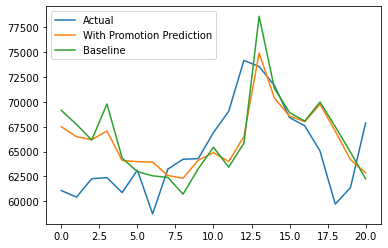

In [120]:
plt.plot(actual.values, label='Actual')
plt.plot(predictions, label='With Promotion Prediction')
plt.plot(predictions2, label='Baseline')
plt.legend()
plt.show()

In [107]:
## Include confidence intervals, incldue weeks, visualize programs, try logged data, save errors to look at 
# random walk (t-1) = additional baseline for t+4
# Investigate tactic spend? Might evenly distribute investment across tactics employed
# Try normal regression throw everything in. Another baseline
# Exponential smoothing? probably similar to Arima

df_rt.tail(10)

,covid_panic,UNK,Program Development Costs,Ecommerce,Sampling,In-Store Marketing,Price / Promotion / Couponing,Retailer Partnership,Printed Out-of-Store Media,Unallocated Funding,Digital Marketing,SalesUnit
95,0,0,0,2,0,0,1,0,0,0,0,69061
96,0,0,0,2,0,0,1,0,0,0,0,74181
97,0,0,0,2,0,0,1,0,0,0,0,73566
98,0,0,0,2,0,0,1,0,0,0,0,71665
99,0,0,0,2,0,0,1,0,0,0,0,68434
100,0,0,0,2,0,0,1,0,0,0,0,67595
101,0,0,0,2,0,0,1,0,0,0,0,65071
102,0,0,1,2,0,0,1,0,0,0,0,59724
103,0,0,1,2,0,0,1,0,0,0,0,61365
104,0,0,1,2,0,0,1,0,0,0,0,67892


In [447]:
## Walk forward RF validation

temp=series_to_supervised(df_rt,4,1)
error, actual, predictions, model=walk_forward_rf_validation(temp, n_test)

>expected=61084.0, predicted=67423.2
>expected=60425.0, predicted=66475.9
>expected=62277.0, predicted=66393.2
>expected=62389.0, predicted=67554.1
>expected=60877.0, predicted=64938.6
>expected=63140.0, predicted=64124.3
>expected=58733.0, predicted=63823.3
>expected=63239.0, predicted=63401.2
>expected=64234.0, predicted=62622.2
>expected=64300.0, predicted=63731.3
>expected=66923.0, predicted=64948.9
>expected=69061.0, predicted=63875.3
>expected=74181.0, predicted=66434.9
>expected=73566.0, predicted=74553.6
>expected=71665.0, predicted=69588.9
>expected=68434.0, predicted=68437.9
>expected=67595.0, predicted=68251.2
>expected=65071.0, predicted=69676.5
>expected=59724.0, predicted=67401.0
>expected=61365.0, predicted=64649.2
>expected=67892.0, predicted=62862.6


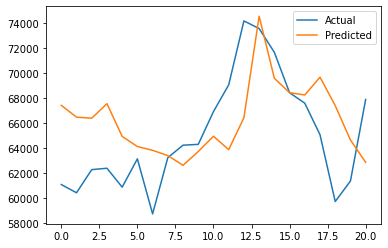

In [448]:
plt.plot(actual.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [469]:
error

3394.90938095238

In [108]:
## Show importance of features

variables=temp.columns[:-1]
pd.DataFrame({'Importance': model.feature_importances_}, index=variables).sort_values(['Importance'], ascending=False)

,Importance
SalesUnit_t-1,0.747663
In-Store Marketing_t,0.089063
In-Store Marketing_t-1,0.068740
covid_panic_t,0.027491
covid_panic_t-1,0.022609
UNK_t,0.014052
UNK_t-1,0.013949
Digital Marketing_t-1,0.006477
Digital Marketing_t,0.004130
Ecommerce_t-1,0.001568


In [362]:
temp=series_to_supervised(list(df_rt["SalesUnit"]),1,1)
#train, test=train_test_split(df_rt,n_test)
error, unsure, predictions=walk_forward_validation(temp, n_test)


>expected=61084.0, predicted=64952.7
>expected=60425.0, predicted=75068.8
>expected=62277.0, predicted=73245.3
>expected=62389.0, predicted=73955.2
>expected=60877.0, predicted=67063.0
>expected=63140.0, predicted=72857.0
>expected=58733.0, predicted=75043.6
>expected=63239.0, predicted=64330.5
>expected=64234.0, predicted=65112.2
>expected=64300.0, predicted=64997.2
>expected=66923.0, predicted=64313.5
>expected=69061.0, predicted=66642.6
>expected=74181.0, predicted=63962.2
>expected=73566.0, predicted=90701.6
>expected=71665.0, predicted=75533.0
>expected=68434.0, predicted=68042.3
>expected=67595.0, predicted=66520.3
>expected=65071.0, predicted=69890.7
>expected=59724.0, predicted=65430.6
>expected=61365.0, predicted=63283.7
>expected=67892.0, predicted=63908.3


In [386]:
unsure

84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0
91     0.0
92     0.0
93     0.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
Name: var2(t-1), dtype: float64

In [366]:
unsure.values

array([61084, 60425, 62277, 62389, 60877, 63140, 58733, 63239, 64234,
       64300, 66923, 69061, 74181, 73566, 71665, 68434, 67595, 65071,
       59724, 61365, 67892], dtype=int64)

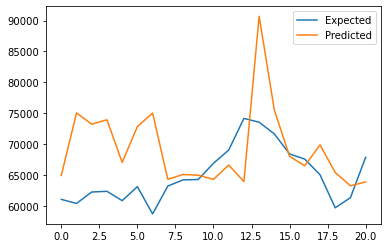

In [367]:
plt.plot(unsure.values, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

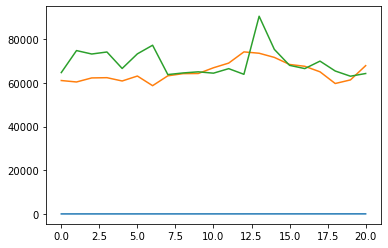

In [360]:
plt.plot(unsure, label='Expected')
plt.plot(predictions, label='Predicted')
plt.show()

In [343]:
series=df_rt["SalesUnit"]
temp=series_to_supervised(list(series),1,1)
error, unsure, predictions=walk_forward_validation(temp, n_test)
error

>expected=61084.0, predicted=64417.4
>expected=60425.0, predicted=74706.2
>expected=62277.0, predicted=73323.4
>expected=62389.0, predicted=73986.7
>expected=60877.0, predicted=66625.2
>expected=63140.0, predicted=72859.1
>expected=58733.0, predicted=75487.1
>expected=63239.0, predicted=64161.1
>expected=64234.0, predicted=64577.8
>expected=64300.0, predicted=64970.6
>expected=66923.0, predicted=64543.2
>expected=69061.0, predicted=66637.4
>expected=74181.0, predicted=63966.4
>expected=73566.0, predicted=90449.2
>expected=71665.0, predicted=75394.2
>expected=68434.0, predicted=67995.5
>expected=67595.0, predicted=66469.2
>expected=65071.0, predicted=69990.9
>expected=59724.0, predicted=65463.0
>expected=61365.0, predicted=62873.5
>expected=67892.0, predicted=64080.3


6075.726285714287

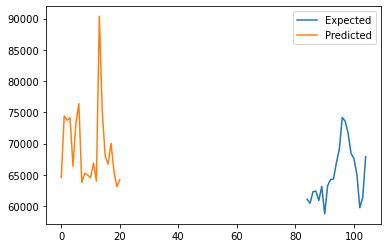

In [341]:
plt.plot(unsure, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [268]:
test_percent = .2
n_test = math.ceil(test_percent * df_rt.shape[0])
n_test
train, test=train_test_split(temp, n_test) # good
test
history = [x for x in train] # Lists all the column names in train
history=np.asarray(history)
history.append(1)
history

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [178]:
history = [x for x in train] # Lists all the column names in train
i=0
testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
temp=np.asarray(history)
temp
#mae, y, yhat = walk_forward_validation(df_rt, n_test)

array(['SalesDollar', 'BrandName', 'WeekBeginningDate', 'WeekEndingDate',
       'ProgramId_19793', 'ProgramId_14058', 'ProgramId_20676',
       'ProgramId_20789', 'ProgramId_18089', 'ProgramId_18429',
       'ProgramId_19973', 'ProgramId_13560', 'ProgramId_12171',
       'ProgramId_17597', 'ProgramId_19974', 'ProgramId_20699',
       'ProgramId_20266', 'ProgramId_20056', 'ProgramId_20047',
       'ProgramId_14014', 'ProgramId_18276', 'ProgramId_22202',
       'ProgramId_19782', 'ProgramId_20790', 'ProgramId_14831',
       'ProgramId_19847', 'ProgramId_20598', 'ProgramId_14386',
       'ProgramId_18428', 'ProgramId_19881', 'UNK', 'Digital Marketing',
       'Retailer Partnership', 'Price / Promotion / Couponing',
       'Printed Out-of-Store Media', 'In-Store Marketing', 'Sampling',
       'Ecommerce', 'Unallocated Funding', 'Program Development Costs',
       'SalesUnit_lag1', 'SalesUnit'], dtype='<U29')

In [434]:
## Impute average sales lags. MAKE FUNCTION OR ADD TO LAG DEFINITION!

avg=np.mean(df_rt["SalesUnit_lag1"])
avg
df_rt.SalesUnit_lag1=df_rt["SalesUnit_lag1"].fillna(avg)
df_rt
avg=np.mean(df_rt["SalesUnit_lag2"])
avg
df_rt.SalesUnit_lag2=df_rt["SalesUnit_lag2"].fillna(avg)
df_rt
avg=np.mean(df_rt["SalesUnit_lag3"])
avg
df_rt.SalesUnit_lag3=df_rt["SalesUnit_lag3"].fillna(avg)
df_rt
avg=np.mean(df_rt["SalesUnit_lag4"])
avg
df_rt.SalesUnit_lag4=df_rt["SalesUnit_lag4"].fillna(avg)
df_rt

,SalesUnit,SalesDollar,BrandName,WeekBeginningDate,WeekEndingDate,ProgramId_20056,ProgramId_12171,ProgramId_14058,ProgramId_22202,ProgramId_19881,...,Sampling,Unallocated Funding,Program Development Costs,Retailer Partnership,Printed Out-of-Store Media,SalesUnit_lag1,SalesUnit_lag2,SalesUnit_lag3,SalesUnit_lag4,Week
0,63846,70397.87,Knorr,2019-10-13,2019-10-19,0,0,0,0,0,...,0,0,0,0,0,78121.125,78283.805825,78465.764706,78598.386139,0
1,61198,69223.91,Knorr,2019-10-20,2019-10-26,0,0,0,0,0,...,0,0,0,0,0,63846.000,78283.805825,78465.764706,78598.386139,1
2,63071,71674.56,Knorr,2019-10-27,2019-11-02,0,0,0,0,0,...,0,0,0,0,0,61198.000,63846.000000,78465.764706,78598.386139,2
3,64799,73464.24,Knorr,2019-11-03,2019-11-09,0,0,0,0,0,...,0,0,0,0,0,63071.000,61198.000000,63846.000000,78598.386139,3
4,64740,73688.23,Knorr,2019-11-10,2019-11-16,0,0,0,0,0,...,0,0,0,0,0,64799.000,63071.000000,61198.000000,63846.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,67595,72285.74,Knorr,2021-09-12,2021-09-18,0,0,0,0,1,...,0,0,0,0,0,68434.000,71665.000000,73566.000000,74181.000000,100
101,65071,70714.54,Knorr,2021-09-19,2021-09-25,0,0,0,0,1,...,0,0,0,0,0,67595.000,68434.000000,71665.000000,73566.000000,101
102,59724,67351.13,Knorr,2021-09-26,2021-10-02,0,0,0,1,1,...,0,0,1,0,0,65071.000,67595.000000,68434.000000,71665.000000,102
103,61365,69359.67,Knorr,2021-10-03,2021-10-09,0,0,0,1,1,...,0,0,1,0,0,59724.000,65071.000000,67595.000000,68434.000000,103


In [435]:
## Create training data. Y: SalesUnit. X: BrandName (eventually), Programs, Tactics, Lags
## Remove: Week, SalesDollar, WeekBeginningDate, WeekEndingDate

df_rt.columns
cut=["SalesUnit","SalesDollar","WeekBeginningDate","WeekEndingDate","BrandName",'Ecommerce', 'Digital Marketing',
       'UNK', 'Price / Promotion / Couponing', 'In-Store Marketing',
       'Sampling', 'Unallocated Funding', 'Program Development Costs',
       'Retailer Partnership', 'Printed Out-of-Store Media']
X_orig_train=df_rt.loc[:, ~df_rt.columns.isin(cut)]
remaining_vars=df_rt.columns[~df_rt.columns.isin(cut)]
Y_orig_train=df_rt["SalesUnit"]
X_orig_train

,ProgramId_20056,ProgramId_12171,ProgramId_14058,ProgramId_22202,ProgramId_19881,ProgramId_19974,ProgramId_20266,ProgramId_14014,ProgramId_14831,ProgramId_19782,...,ProgramId_19793,ProgramId_19973,ProgramId_20790,ProgramId_20047,ProgramId_18428,SalesUnit_lag1,SalesUnit_lag2,SalesUnit_lag3,SalesUnit_lag4,Week
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,78121.125,78283.805825,78465.764706,78598.386139,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,63846.000,78283.805825,78465.764706,78598.386139,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,61198.000,63846.000000,78465.764706,78598.386139,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,63071.000,61198.000000,63846.000000,78598.386139,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,64799.000,63071.000000,61198.000000,63846.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,68434.000,71665.000000,73566.000000,74181.000000,100
101,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,67595.000,68434.000000,71665.000000,73566.000000,101
102,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,65071.000,67595.000000,68434.000000,71665.000000,102
103,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,59724.000,65071.000000,67595.000000,68434.000000,103


In [469]:
## Splitting original data into training (75%) and test (25%) data

X_train, X_test, Y_train, Y_test = train_test_split(X_orig_train, Y_orig_train, test_size = 0.25, random_state = 201)

## Splitting training data into training (90%) and validation (10%) data

X_train, X_val, Y_train, Y_val =  train_test_split(X_train, Y_train, test_size = 0.25, random_state = 200)

(20,)

## Modeling

### Regression Tree 1 (w/o COVID variable)

In [437]:
## Decision tree

rt = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=4,
                           max_features=.5,
                           min_impurity_decrease=.001,
                           ccp_alpha=.1,
                           random_state=201)
rt_model = rt.fit(X_train, Y_train)
rt_pred = rt_model.predict(X_val)

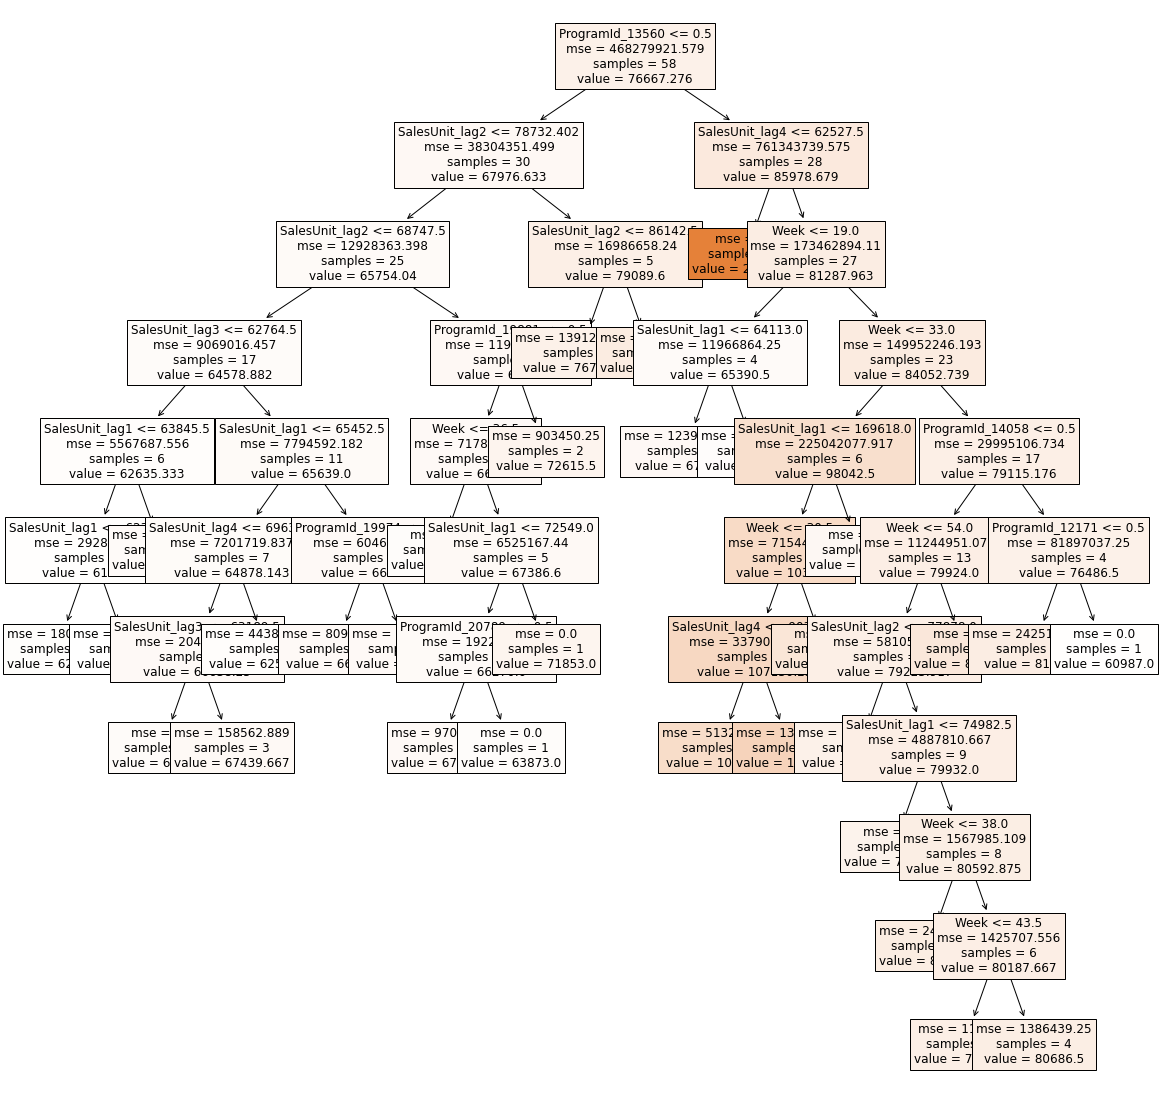

In [438]:
## Plot tree

plt.figure(figsize=(20,20))
plot_tree(rt_model, feature_names=X_train.columns, filled=True, fontsize=12)
plt.show()

In [439]:
## Show importance of features

pd.DataFrame({'Importance': rt_model.feature_importances_}, index=remaining_vars).sort_values(['Importance'], ascending=False)

,Importance
SalesUnit_lag4,0.621335
ProgramId_13560,0.173738
Week,0.114450
SalesUnit_lag1,0.041141
SalesUnit_lag2,0.032394
ProgramId_12171,0.011857
ProgramId_19881,0.001880
SalesUnit_lag3,0.001582
ProgramId_14058,0.001338
ProgramId_20789,0.000284


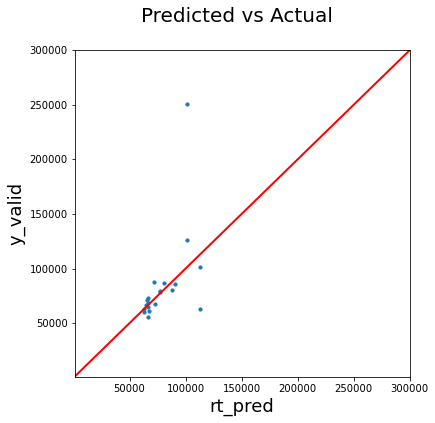

28     126608
76      73097
77      55266
50      78558
5       66627
26     101266
16      62933
21     250394
82      68852
33      86219
9       70943
63      80663
103     61365
54      86354
51      79333
85      60425
64      87990
79      64551
100     67595
24      63055
Name: SalesUnit, dtype: int64

In [440]:
## Plotting predictions against actual validation data...

plt.figure(figsize=(6,6))
plt.scatter(rt_pred, np.array(Y_val), s = 10)
plt.xlim(1000, 300000)
plt.ylim(1000, 300000)
plt.plot([1000, 300000], [1000, 300000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rt_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()
Y_val

In [441]:
accuracy(Y_val, rt_pred)

RMSE,MAE,R^2,RMSLE
36067.493026,15785.758333,0.237621,0.258578


<AxesSubplot:>

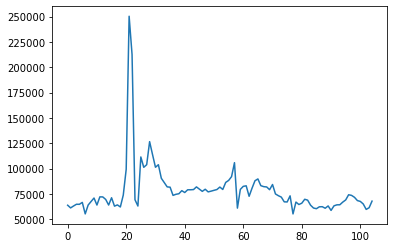

In [471]:
## Where are these outliers coming from?

df_rt[df_rt.SalesUnit>100000] # probably COVID...
df_rt.SalesUnit.plot()

In [443]:
## Optimization attempt
'''
rt = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=4,
                           max_features=.5,
                           min_impurity_decrease=.001,
                           ccp_alpha=.1,
                           random_state=201)
                        
'''


parameters = {'max_depth': [5, 10, 20, 50],
              'min_samples_split': [2, 4, 10],
              'max_features':[.1, .5, .75],
              'min_impurity_decrease': [.001, .01, .1, 1],
             'ccp_alpha':[0, 0.1, 0.01]}

gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features = .5, ccp_alpha=0, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus, scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [444]:
gs_rt_model.fit(X_train, Y_train)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=0, max_features=0.5,
                                             random_state=201),
             n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.1, 0.01],
                         'max_depth': [5, 10, 20, 50],
                         'max_features': [0.1, 0.5, 0.75],
                         'min_impurity_decrease': [0.001, 0.01, 0.1, 1],
                         'min_samples_split': [2, 4, 10]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [445]:
## Ideal parameters for RT

gs_rt_model.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'max_features': 0.1,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 10}

In [446]:
## Predict using ideal hyperparameters

gs_rt_pred = gs_rt_model.predict(X_val)
accuracy(Y_val, gs_rt_pred)

RMSE,MAE,R^2,RMSLE
40838.306499,16926.969246,0.022595,0.302512


### Regression Tree 2: Adjusting for COVID

In [447]:
## Adjusted data for COVID

df_rt["covid_panic"]=0 
df_rt.iloc[15:35].covid_panic=1 # Eyeballed this. Probably need to pick something that's continuous fear rep.
df_rt.covid_panic.value_counts()

D:\Users\nkeeley\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0    85
1    20
Name: covid_panic, dtype: int64

In [448]:
## Create training data. Y: SalesUnit. X: BrandName (eventually), Programs, Tactics, Lags
## Remove: Week, SalesDollar, WeekBeginningDate, WeekEndingDate

df_rt.columns
cut=["SalesUnit","SalesDollar","WeekBeginningDate","WeekEndingDate","BrandName",'Ecommerce', 'Digital Marketing',
       'UNK', 'Price / Promotion / Couponing', 'In-Store Marketing',
       'Sampling', 'Unallocated Funding', 'Program Development Costs',
       'Retailer Partnership', 'Printed Out-of-Store Media']
X_orig_train=df_rt.loc[:, ~df_rt.columns.isin(cut)]
remaining_vars=df_rt.columns[~df_rt.columns.isin(cut)]
Y_orig_train=df_rt["SalesUnit"]
X_orig_train.columns

Index(['ProgramId_20056', 'ProgramId_12171', 'ProgramId_14058',
       'ProgramId_22202', 'ProgramId_19881', 'ProgramId_19974',
       'ProgramId_20266', 'ProgramId_14014', 'ProgramId_14831',
       'ProgramId_19782', 'ProgramId_13560', 'ProgramId_18429',
       'ProgramId_19847', 'ProgramId_18276', 'ProgramId_20676',
       'ProgramId_20789', 'ProgramId_20598', 'ProgramId_20699',
       'ProgramId_18089', 'ProgramId_14386', 'ProgramId_17597',
       'ProgramId_19793', 'ProgramId_19973', 'ProgramId_20790',
       'ProgramId_20047', 'ProgramId_18428', 'SalesUnit_lag1',
       'SalesUnit_lag2', 'SalesUnit_lag3', 'SalesUnit_lag4', 'Week',
       'covid_panic'],
      dtype='object')

In [449]:
## Splitting original data into training (75%) and test (25%) data

X_train, X_test, Y_train, Y_test = train_test_split(X_orig_train, Y_orig_train, test_size = 0.25, random_state = 201)

## Splitting training data into training (90%) and validation (10%) data

X_train, X_val, Y_train, Y_val =  train_test_split(X_train, Y_train, test_size = 0.25, random_state = 200)

In [450]:
## Decision tree

rt = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=4,
                           max_features=.5,
                           min_impurity_decrease=.001,
                           ccp_alpha=.1,
                           random_state=201)
rt_model = rt.fit(X_train, Y_train)
rt_pred = rt_model.predict(X_val)

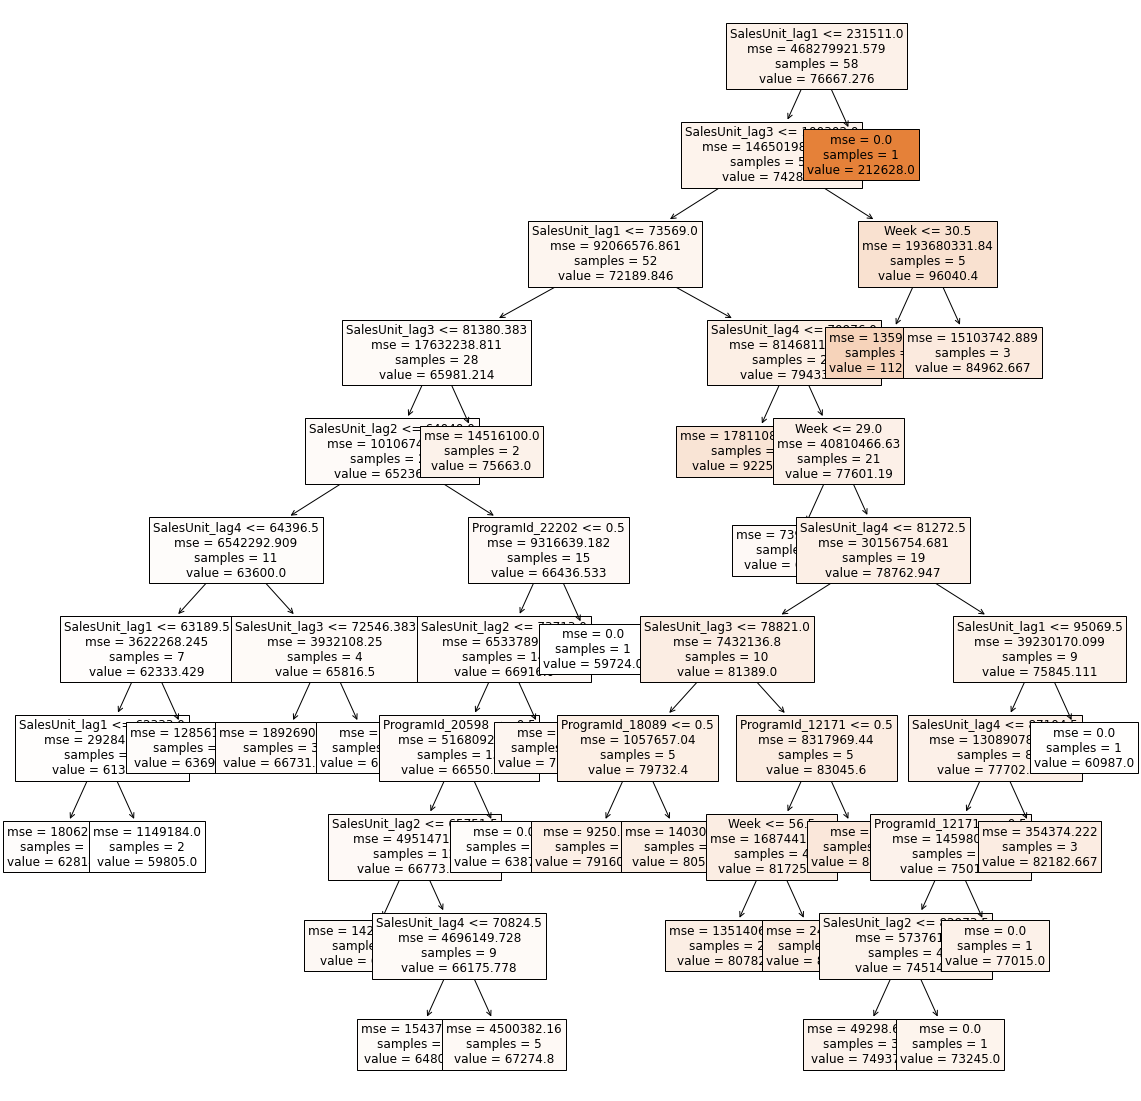

In [451]:
## Plot tree

plt.figure(figsize=(20,20))
plot_tree(rt_model, feature_names=X_train.columns, filled=True, fontsize=12)
plt.show()

In [452]:
## Show importance of features

pd.DataFrame({'Importance': rt_model.feature_importances_}, index=remaining_vars).sort_values(['Importance'], ascending=False)

,Importance
SalesUnit_lag1,0.808685
SalesUnit_lag3,0.107023
Week,0.045057
SalesUnit_lag4,0.032109
SalesUnit_lag2,0.003413
ProgramId_22202,0.001823
ProgramId_12171,0.001505
ProgramId_20598,0.000293
ProgramId_18089,0.000093
ProgramId_20699,0.000000


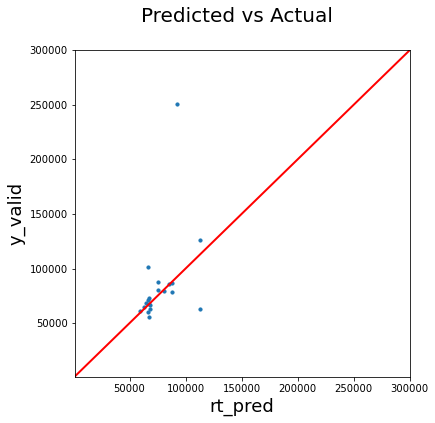

28     126608
76      73097
77      55266
50      78558
5       66627
26     101266
16      62933
21     250394
82      68852
33      86219
9       70943
63      80663
103     61365
54      86354
51      79333
85      60425
64      87990
79      64551
100     67595
24      63055
Name: SalesUnit, dtype: int64

In [453]:
## Plotting predictions against actual validation data...

plt.figure(figsize=(6,6))
plt.scatter(rt_pred, np.array(Y_val), s = 10)
plt.xlim(1000, 300000)
plt.ylim(1000, 300000)
plt.plot([1000, 300000], [1000, 300000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rt_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()
Y_val

In [454]:
accuracy(Y_val, rt_pred)

RMSE,MAE,R^2,RMSLE
38377.486971,16605.593333,0.136838,0.286377


In [455]:
## Optimization attempt
'''
rt = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=4,
                           max_features=.5,
                           min_impurity_decrease=.001,
                           ccp_alpha=.1,
                           random_state=201)
                        
'''


parameters = {'max_depth': [5, 10, 20, 50],
              'min_samples_split': [2, 4, 10],
              'max_features':[.1, .5, .75],
              'min_impurity_decrease': [.001, .01, .1, 1],
             'ccp_alpha':[0, 0.1, 0.01]}

gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features = .5, ccp_alpha=0, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus, scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [456]:
gs_rt_model.fit(X_train, Y_train)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=0, max_features=0.5,
                                             random_state=201),
             n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.1, 0.01],
                         'max_depth': [5, 10, 20, 50],
                         'max_features': [0.1, 0.5, 0.75],
                         'min_impurity_decrease': [0.001, 0.01, 0.1, 1],
                         'min_samples_split': [2, 4, 10]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [457]:
## Ideal parameters for RT

gs_rt_model.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'max_features': 0.1,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 4}

In [458]:
## Predict using ideal hyperparameters

gs_rt_pred = gs_rt_model.predict(X_val)
accuracy(Y_val, gs_rt_pred)

RMSE,MAE,R^2,RMSLE
36734.906091,16719.208333,0.209145,0.266420


### Random Forest

In [389]:
## Random forest

rf = RandomForestRegressor(n_estimators=1000,
                           max_features=10,
                           min_samples_leaf=2,
                           random_state=201,
                           ccp_alpha=10,
                           n_jobs=num_cpus)
rf_model = rf.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_val)

In [390]:
## Show importance of features

pd.DataFrame({'Importance': rf_model.feature_importances_}, index=remaining_vars).sort_values(['Importance'], ascending=False)

,Importance
SalesUnit_lag1,0.266166
SalesUnit_lag2,0.184745
SalesUnit_lag4,0.154193
SalesUnit_lag3,0.104770
Week,0.079320
covid_panic,0.077679
ProgramId_14831,0.048388
ProgramId_13560,0.043223
ProgramId_14386,0.021190
ProgramId_20699,0.005187


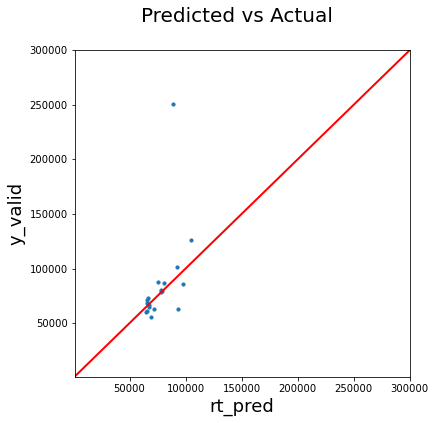

In [391]:
## Plotting predictions against actual validation data...

plt.figure(figsize=(6,6))
plt.scatter(rf_pred, np.array(Y_val), s = 10)
plt.xlim(1000, 300000)
plt.ylim(1000, 300000)
plt.plot([1000, 300000], [1000, 300000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rt_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

In [392]:
## Evaluate accuracy

accuracy(Y_val, rf_pred)


RMSE,MAE,R^2,RMSLE
37697.564363,15302.685450,0.167152,0.266416


In [461]:
## Optimization attempt for RF
'''
rf = RandomForestRegressor(n_estimators=1000,
                           max_features=10,
                           min_samples_leaf=2,
                           random_state=201,
                           ccp_alpha=10,
                           n_jobs=num_cpus)
                        
'''


parameters = {'n_estimators': [10, 500, 1000],
              'max_features':[.1, .5, .75],
              'min_samples_leaf': [2, 5, 10],
             'ccp_alpha':[0, 0.01, 10]}

gs_rf_model = GridSearchCV(RandomForestRegressor(n_estimators = 10, max_features = .5, ccp_alpha=0, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus, scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [462]:
%time
gs_rf_model.fit(X_train, Y_train)

Wall time: 0 ns


GridSearchCV(cv=4,
             estimator=RandomForestRegressor(ccp_alpha=0, max_features=0.5,
                                             n_estimators=10,
                                             random_state=201),
             n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.01, 10],
                         'max_features': [0.1, 0.5, 0.75],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [464]:
## Ideal parameters for RF

gs_rf_model.best_params_

{'ccp_alpha': 0,
 'max_features': 0.75,
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [466]:
## Predict using ideal hyperparameters

gs_rf_pred = gs_rf_model.predict(X_val)
accuracy(Y_val, gs_rf_pred)

RMSE,MAE,R^2,RMSLE
36343.170255,14663.606167,0.225922,0.251674


### Boosted Trees

In [393]:
## Fit boosted tree model

xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         ccp_alpha=10,
                         random_state=201)
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_val)

[11:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [394]:
## Importance

pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=remaining_vars).sort_values(['Importance'], ascending=False)

,Importance
ProgramId_14831,0.393014
SalesUnit_lag1,0.301295
covid_panic,0.134742
ProgramId_14058,0.056491
SalesUnit_lag4,0.043245
Week,0.025387
SalesUnit_lag2,0.017315
ProgramId_19974,0.006524
ProgramId_20789,0.004710
ProgramId_22202,0.004428


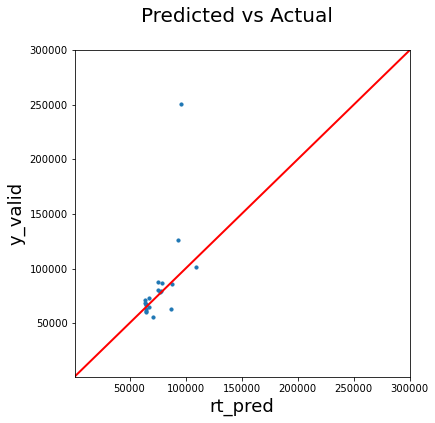

In [395]:
## Plotting predictions against actual validation data...

plt.figure(figsize=(6,6))
plt.scatter(xgb_pred, np.array(Y_val), s = 10)
plt.xlim(1000, 300000)
plt.ylim(1000, 300000)
plt.plot([1000, 300000], [1000, 300000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('rt_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

In [396]:
accuracy(Y_val, xgb_pred)

RMSE,MAE,R^2,RMSLE
36283.738782,14969.579297,0.228452,0.251352


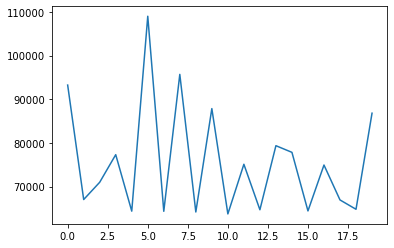

In [397]:
plt.plot(xgb_pred)

In [467]:
## Optimization attempt for RF
'''
xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         ccp_alpha=10,
                         random_state=201)
'''


parameters = {'max_depth': [3, 10, 20],
              'n_estimators':[50, 500, 5000],
              'learning_rate': [0.001, 0.01, 0.1],
             'ccp_alpha':[0, 0.01, 10]}

gs_xgb_model = GridSearchCV(XGBRegressor(max_depth = 3, n_estimators = 50, ccp_alpha=0, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus, scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [468]:
%time
gs_xgb_model.fit(X_train, Y_train)

Wall time: 0 ns
[16:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None, ccp_alpha=0,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=nan, monotone_constrain...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=201, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,


In [472]:
## Ideal parameters for RF

gs_xgb_model.best_params_

{'ccp_alpha': 0, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}

In [474]:
## Predict using ideal hyperparameters

gs_xgb_pred = gs_xgb_model.predict(X_val)
accuracy(Y_val, gs_xgb_pred)

RMSE,MAE,R^2,RMSLE
36659.866192,14659.037695,0.212373,0.255595
